# Telecom Churn Case Study

*  By - Sabyasachi Parida

## Problem Statement:
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Postpaid: Customer inform beforehand
Prepaid: Customer stop using services and it is difficult to know whether someone has churned or has temporarily stopped using services

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. 

### Churn definition:
- Revenue based churn: Customers who dont generate any revenue by using the services offered
- Usage based churn: Customers who dont use any services over a period of time. Defining the period might be tricky

In this project, you will use the usage-based definition to define churn.

### High Value churn:
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metrics and predict churn only on high-value customers.

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

## 3 Phases of Customer lifecycle with operator:
i. Good -> Customer is happy with services
ii. Action -> Customer gets good offer from competitor, unhappy with services of current. Customer behavior begins to change. Identification of churn-probable customers needs to be done in this phase and corrective action needs to be taken.
iii. Churn -> Customer is said ot be churned. Churn is defined based on this phase. At time of prediction, this data is not available. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## Steps that we will follow 
1. Reading & Understanding Data
2. Data Pre-processing
3. Treating Nulls and Dropping September Columns
4. Exploratory Data Analysis (EDA)
5. Data Preparation - Creating derived Variables
6. Outlier Treatment
7. Power transformation (to stabilize variance, make the data more normal distribution-like)
8. Dummy variable Creation for Categorical features
9. Model Building
    - 9.1 Interpretable model
	- 9.2 RFE
    - 9.3 Grid search cv to find the best weight and fit
10. Model Building Using PCA
11. Hyper Parameter Tuning After PCA and Base modeling
12. Comprehensive Model evaluation with the Model Scores
13. Best Model Interpretation
	- 13.1 High Performance Model - LogisticRegression with HTune interpretation
	- 13.2 13.2 IntpModel - LogisticRegression - Interpretation
14. Refined Recomendations /Stratigies 

## 1. Reading & Understanding Data

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import mean
from datetime import date
from matplotlib import pyplot as plt 
import seaborn as sns
import time

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer

from scipy import stats
from scipy.stats import skew, norm

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

import statsmodels.api as sm
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.decomposition import PCA

RANDOM_STATE = 42 #Creating the Random State for Future Use 

# visulaisation
from matplotlib.pyplot import xticks
%matplotlib inline

#Code to show all columns of dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
telecom_churn = pd.read_csv(r'D:\Data Science\Telecom Churn\telecom_churn_data.csv', 
                            sep=',', encoding = "ISO-8859-1") # This should be the actual path where the file exists .
telecom_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [3]:
telecom_churn.shape

(99999, 226)

In [4]:
telecom_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


### 1.1 Checking the Uniqueness of Data in the Dataset  

In [5]:
## If the mobile number is duplicated 
print(sum(telecom_churn.duplicated(subset = 'mobile_number')) == 0)
## If true that means there are no duplicte mobile number 

True


## 2. Data Pre-processing

### 2.1 User defined functions to use during Data pre-processing 

In [6]:
## create a generic function to remove rows or columns based on parameter provided 
def removeNulls(dataframe , axis=1, percentage=0.3):
    '''
    it will remove rows or columns based on the input provided 
    dataframe = name of dataframe 
    axis =1 default for columns , if rows are required we would need to pass 0 
    
    default percentage check is 30%
    
    '''
    df= dataframe.copy()
    ishape = df.shape
    if axis==0:
        rownames= df.transpose().isnull().sum()
        rownames= list(rownames[rownames.values > percentage*len(df)].index)
        print(rownames)
        df.drop(df.index[rownames],inplace=True)
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames=(df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percentage].index)
        print(colnames)
        df.drop(labels = colnames,axis =1,inplace=True)   
        print("\nNumber of Columns dropped\t: ",len(colnames))
    
    print("\n Previous Shape -",ishape,"\n New Shape",df.shape)
    return df

### 2.2 Inspect Null % 

In [7]:
colnames=(telecom_churn.isnull().sum()*100/len(telecom_churn)) 
colnames 

mobile_number                0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.018010
std_og_t2o_mou               1.018010
loc_ic_t2o_mou               1.018010
last_date_of_month_6         0.000000
last_date_of_month_7         0.601006
last_date_of_month_8         1.100011
last_date_of_month_9         1.659017
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
arpu_9                       0.000000
onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_

###  2.3 Creating derived columns in order to Filter high value customers

As per the objective, let's first filter out the dataset to have only the high value customer records.

In [8]:
#Impute total_rech_data and av_rech_amt_data.
#Below are the columns related to recharge 
amt_recharge_columns = ['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9'
                     ,'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']

## Null signifies they didnt recharde hence filling it with 0 ( meaningfull missing imputation)
for col in amt_recharge_columns:
    telecom_churn[col].fillna(0,inplace=True)
telecom_churn[amt_recharge_columns].isnull().sum()

total_rech_data_6     0
total_rech_data_7     0
total_rech_data_8     0
total_rech_data_9     0
av_rech_amt_data_6    0
av_rech_amt_data_7    0
av_rech_amt_data_8    0
av_rech_amt_data_9    0
dtype: int64

### 2.3.1 Derive columns creation For total recharge amount 
 
 Note :- We will be creating more derived feaures in future steps

In [9]:
## Getting the total rechearge amount on the basis of the number of recharge * av rechearge amount 
telecom_churn['total_rech_data_amt_6'] = telecom_churn['total_rech_data_6'] * telecom_churn['av_rech_amt_data_6']
telecom_churn['total_rech_data_amt_7'] = telecom_churn['total_rech_data_7'] * telecom_churn['av_rech_amt_data_7']
telecom_churn['total_rech_data_amt_8'] = telecom_churn['total_rech_data_8'] * telecom_churn['av_rech_amt_data_8']
telecom_churn['total_rech_data_amt_9'] = telecom_churn['total_rech_data_9'] * telecom_churn['av_rech_amt_data_9']

In [10]:
#Dropping total_rech_data_X and av_rech_amt_data_X
telecom_churn.drop(amt_recharge_columns, axis=1, inplace=True)
telecom_churn.shape

(99999, 222)

count    99999.000000
mean       485.328068
std        869.423594
min          0.000000
25%        128.000000
50%        275.000000
70%        478.000000
75%        553.000000
max      61236.000000
Name: telecom_av_rech_6_7, dtype: float64


Text(0.5, 1.0, 'Average Recharge amount for Jun & July')

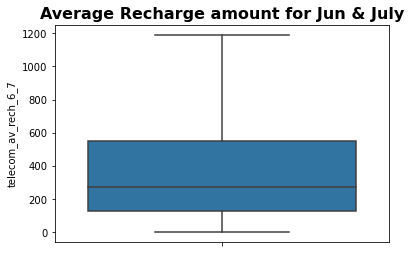

In [11]:
# Get the average recharge amount for 6 and 7 month 
telecom_churn['telecom_av_rech_6_7'] = ( telecom_churn['total_rech_amt_6'].fillna(0)
                                     + telecom_churn['total_rech_data_amt_6'].fillna(0)
                                     + telecom_churn['total_rech_amt_7'].fillna(0)
                                     + telecom_churn['total_rech_data_amt_7'].fillna(0)
                                    ) / 2

# 70th percentile of calculated average amount.
print(telecom_churn['telecom_av_rech_6_7'].describe(percentiles=[.25,.50,.70,.75]))
ax = sns.boxplot(y=telecom_churn['telecom_av_rech_6_7'],showfliers=False)
plt.title('Average Recharge amount for Jun & July', weight='bold', FontSize = 16)

In [12]:
# Get the data more than or equal to 70th percentile of calculated average amount.
telecom_churn = telecom_churn.loc[(telecom_churn['telecom_av_rech_6_7'] >= np.percentile(telecom_churn['telecom_av_rech_6_7'], 70))]
# drop the average column
telecom_churn.drop(['telecom_av_rech_6_7'], axis=1, inplace=True)

print(telecom_churn.shape)

(30001, 222)


#### Inferences 
- A derived column was created with the average reacharge amount for the month of Jun and Jul (the good phase)
- Those records which came above the 70th percentile of the average recharge amount were taken into consideration as they were the high valued customers.
- Drop the newly derived column which is not required.


### 2.4 Tag Churn and Non churn Customers 

In order to tag the churned customers,
- The following columns were taken into consideration 'total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9'
- The sum of those column was found
- Those were tagged as Churned(1) where the sum was 0 and others were tagged as Non-Churned(0) and deriveed column Churn was created

The following is the code for the same 

In [13]:
# mark the rows as churn if the sum of the total mou and vol of 9 month is 0
tag_churn_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
telecom_churn['churn'] = np.where(telecom_churn[tag_churn_cols].sum(axis=1) == 0, 1, 0 )

In [14]:
telecom_churn['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

**Observation:** From around 30000 customer records, we have about more than 2400 churned customers.

The churn rate would be as follows:

Churn Rate : 8.14%


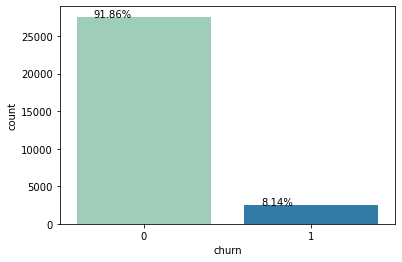

In [15]:
#Churn Distribution
print('\033[1m'+'Churn Rate : {0}%'.format(round(((sum(telecom_churn['churn'])/len(telecom_churn['churn']))*100),2))+ '\033[0m')
ax=sns.countplot(x='churn', data=telecom_churn,palette='YlGnBu')
for p in ax.patches:
    ax.annotate('{:1.2f}%'.format((p.get_height())*100/float(len(telecom_churn.index))), (p.get_x()+0.1, p.get_height()+1))
plt.show();

**Observation:** Churn rate is less than 10% of the overall data available. This indicates that we would need to handle the class imbalance in this classification problem.

## 3. Treating Nulls and Dropping September Columns

### 3.1 Remove columns for the Churn Month i.e September 

Now we can go ahead and remove the Sep(9) month columns as we would not need it further

In [16]:
#Dropping all month 9 cols i.e. _9 cols
col_month_9 = [x for x in telecom_churn.columns if x.split("_")[-1]=="9" ]
col_month_9.append('sep_vbc_3g')
col_month_9

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_9',
 'total_rech_dat

In [17]:
telecom_churn.drop(col_month_9, axis=1, inplace=True)
telecom_churn.shape

(30001, 169)

### 3.2 Drop the columns which has no variance i.e has same value throughout 

In [18]:
unwanted_cols = []
for i in telecom_churn.columns:
    if telecom_churn[i].nunique() == 1:
        print(i, telecom_churn[i].nunique())
        unwanted_cols.append(i)

circle_id 1
loc_og_t2o_mou 1
std_og_t2o_mou 1
loc_ic_t2o_mou 1
last_date_of_month_6 1
last_date_of_month_7 1
last_date_of_month_8 1
std_og_t2c_mou_6 1
std_og_t2c_mou_7 1
std_og_t2c_mou_8 1
std_ic_t2o_mou_6 1
std_ic_t2o_mou_7 1
std_ic_t2o_mou_8 1


In [19]:
telecom_churn.drop(unwanted_cols, axis=1, inplace = True)
telecom_churn.shape

(30001, 156)

### 3.3 Check and convert date variables into datetime

In [20]:
# lets check for columns that can be changed to integers, floats or date types
object_col_data = telecom_churn.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
Name: 0, dtype: object


In [21]:
# convert to datetime
for col in object_col_data.columns:
    telecom_churn[col] = pd.to_datetime(telecom_churn[col])

### 3.4 Check the missing value percentage

In [22]:
#Check the missing data.
total = telecom_churn.isnull().sum().sort_values(ascending=False)
percent = (telecom_churn.isnull().sum()*100/telecom_churn.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
count_rech_3g_8,14048,46.825106
count_rech_2g_8,14048,46.825106
max_rech_data_8,14048,46.825106
arpu_3g_8,14048,46.825106
fb_user_8,14048,46.825106
arpu_2g_8,14048,46.825106
night_pck_user_8,14048,46.825106
date_of_last_rech_data_8,14048,46.825106
date_of_last_rech_data_6,13245,44.148528
count_rech_3g_6,13245,44.148528


### 3.5 Analysing the Columns with missing values greater than 10%  

In [23]:
# Continuous variables with null with more than 10%
high_null = missing_data.index[missing_data.Percent>10]
high_null = telecom_churn[high_null].select_dtypes(include=[np.number]).columns
high_null

Index(['count_rech_3g_8', 'count_rech_2g_8', 'max_rech_data_8', 'arpu_3g_8',
       'fb_user_8', 'arpu_2g_8', 'night_pck_user_8', 'count_rech_3g_6',
       'max_rech_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6',
       'count_rech_2g_6', 'fb_user_6', 'arpu_2g_7', 'arpu_3g_7',
       'count_rech_3g_7', 'count_rech_2g_7', 'max_rech_data_7',
       'night_pck_user_7', 'fb_user_7'],
      dtype='object')

In [24]:
cat_var_list=['fb_user_6', 'night_pck_user_6', 'fb_user_7', 'night_pck_user_7', 'fb_user_8', 'night_pck_user_8']


### Barplot to see how the data is spread into different categories 

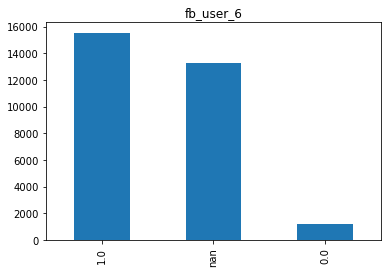

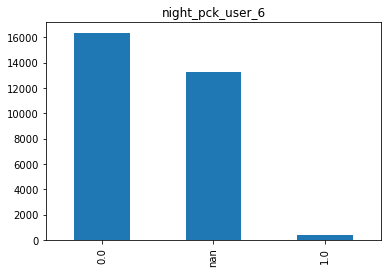

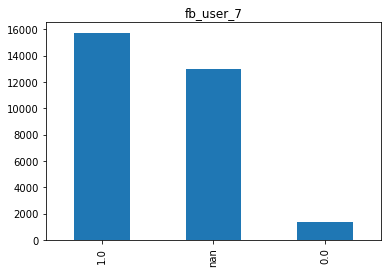

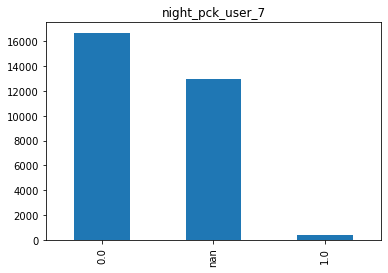

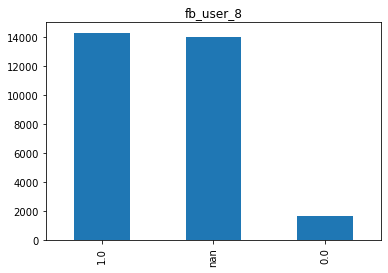

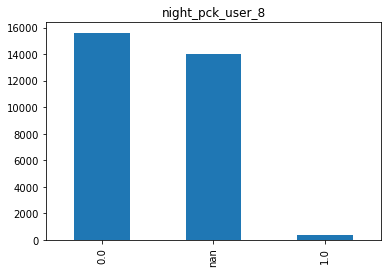

In [25]:
for val in cat_var_list:
    telecom_churn[val].value_counts(dropna=False).plot(kind='bar',title=val)
    plt.show();

### Inferences 
- In those cases where the value is null that signifies the user might not be using that particular features(which we can consider as meaningfull missing) hence we can impute the same with 0.


In [26]:
## Imputing the values with 0
for col in cat_var_list:
    telecom_churn[col] = telecom_churn[col].fillna(0)

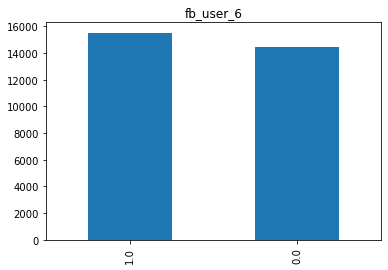

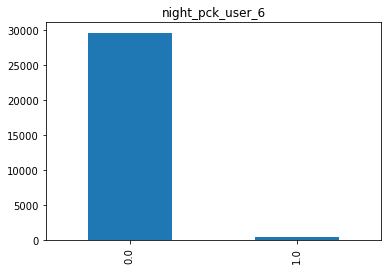

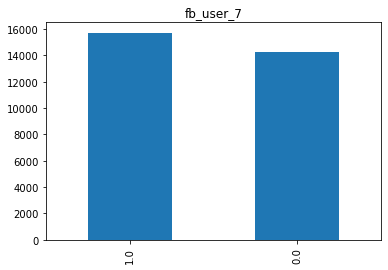

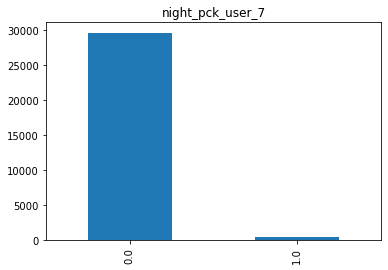

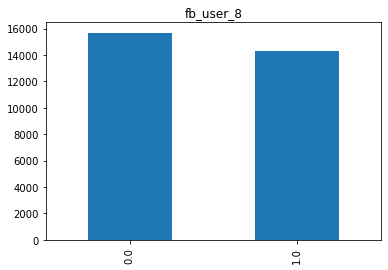

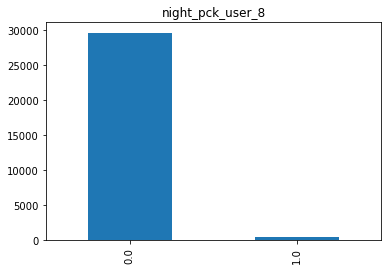

In [27]:
for val in cat_var_list:
    telecom_churn[val].value_counts(dropna=False).plot(kind='bar',title=val)
    plt.show();

In [28]:
# High_null Impute#2 # Meaningfull missing
# filling the missing values of recharge counts, average, 2g and 3g as 0
cols_6 = ['count_rech_3g_6','max_rech_data_6','arpu_3g_6','count_rech_2g_6','arpu_2g_6']
cols_7 = ['count_rech_3g_7','max_rech_data_7','arpu_3g_7','count_rech_2g_7','arpu_2g_7']
cols_8 = ['count_rech_3g_8','max_rech_data_8','arpu_3g_8','count_rech_2g_8','arpu_2g_8']

telecom_churn[cols_6] = telecom_churn[cols_6].fillna(0)
telecom_churn[cols_7] = telecom_churn[cols_7].fillna(0)
telecom_churn[cols_8] = telecom_churn[cols_8].fillna(0)

In [29]:
# Check the null % for high null values.
df = telecom_churn[high_null].isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt


**Observation:** We have imputed all Continuous variables with null > 10%

### 3.6 Impute missing values less Than or Equal to  10%

In [30]:
less_null = missing_data.index[missing_data.Percent<=10] & missing_data.index[missing_data.Percent>0]
less_null = telecom_churn[less_null].select_dtypes(include=[np.number]).columns
less_null

Index(['std_ic_t2m_mou_8', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8',
       'std_og_t2f_mou_8', 'std_og_t2t_mou_8', 'spl_ic_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'std_og_t2m_mou_8', 'loc_ic_t2t_mou_8', 'loc_og_mou_8',
       'loc_og_t2c_mou_8', 'isd_og_mou_8', 'loc_og_t2f_mou_8', 'std_og_mou_8',
       'spl_og_mou_8', 'onnet_mou_8', 'offnet_mou_8', 'og_others_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'std_ic_t2t_mou_8',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6',
       'onnet_mou_6', 'isd_ic_mou_6', 'loc_ic_mou_6', 'spl_ic_mou_6',
       'std_og_t2f_mou_6', 'og_others_6', 'std_ic_mou_6', 'std_og_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_t2f_mou_6', 'std_ic_t2f_mou_6',
       'spl_og_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'offnet_mou_6',
       'loc_ic_t2f_mou_6', 'ic_others_6', 'loc_og_t2m_mou_6', 'isd_og_mou_6',
       'loc_ic_t2m_mou_6', 'loc_og_mou_6', 'roam_og_mou_6', 'std_og_t2t_m

#### Inferences
- There are total 81 Continuous variables having the missing value <= 10%

### 3.7 Impute the missing values with KNN Imputer

Impute continuous features with KNN for continuous variables with null <= 10%

In [31]:
imputer = KNNImputer(n_neighbors=5)

In [32]:
%%time
telecom_churn[less_null] = imputer.fit_transform(telecom_churn[less_null])
telecom_churn[less_null].head()

Wall time: 1min 6s


,std_ic_t2m_mou_8,loc_ic_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,std_og_t2f_mou_8,std_og_t2t_mou_8,spl_ic_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,isd_ic_mou_8,ic_others_8,std_og_t2m_mou_8,loc_ic_t2t_mou_8,loc_og_mou_8,loc_og_t2c_mou_8,isd_og_mou_8,loc_og_t2f_mou_8,std_og_mou_8,spl_og_mou_8,onnet_mou_8,offnet_mou_8,og_others_8,roam_ic_mou_8,roam_og_mou_8,std_ic_t2t_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2t_mou_6,onnet_mou_6,isd_ic_mou_6,loc_ic_mou_6,spl_ic_mou_6,std_og_t2f_mou_6,og_others_6,std_ic_mou_6,std_og_mou_6,loc_og_t2c_mou_6,loc_og_t2f_mou_6,std_ic_t2f_mou_6,spl_og_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,offnet_mou_6,loc_ic_t2f_mou_6,ic_others_6,loc_og_t2m_mou_6,isd_og_mou_6,loc_ic_t2m_mou_6,loc_og_mou_6,roam_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,loc_ic_t2t_mou_6,roam_ic_mou_6,std_og_mou_7,loc_ic_mou_7,loc_ic_t2f_mou_7,loc_ic_t2m_mou_7,spl_og_mou_7,std_ic_t2t_mou_7,loc_ic_t2t_mou_7,og_others_7,std_ic_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7,onnet_mou_7,offnet_mou_7,roam_ic_mou_7,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,isd_og_mou_7,loc_og_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,ic_others_7,isd_ic_mou_7,spl_ic_mou_7,std_og_t2f_mou_7
0,0.00,5.44,0.00,0.00,0.00,0.00,0.0,4.13,1.15,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.402,0.402,0.062,7.204,0.026,0.00,0.248,7.488,0.00,1.078,0.00,0.00,1.12,0.632,6.856,2.176,1.452,0.472,1.098,0.0,2.986,1.50,0.00,0.00,0.00,2.764,0.00,0.00,8.17,0.386,6.252,2.752,0.00,1.53,0.0,2.85,2.85,0.00,0.00,2.21,0.00,0.00,0.00,0.106,0.07,0.566,0.00,0.176,0.00,0.00,0.036,0.00,0.04,0.00
7,141.33,188.04,22.21,193.94,16.68,12.01,0.0,121.19,39.53,31.59,15.14,49.14,27.31,255.79,0.00,10.01,53.23,77.84,6.50,52.29,325.91,0.0,31.64,38.06,30.39,40.28,162.28,51.390,57.840,2.060,427.880,0.210,6.66,0.000,180.540,60.86,0.000,62.13,52.19,4.50,36.890,91.440,453.430,152.160,15.740,308.630,0.0,217.560,422.16,23.74,4.30,49.89,58.140,16.23,75.14,355.23,101.460,221.490,0.000,11.83,32.26,0.0,173.08,126.99,34.24,54.68,567.16,33.49,12.59,31.38,447.380,55.14,0.000,0.18,533.910,23.29,31.76,15.190,14.53,0.00,20.08
8,0.65,15.79,0.00,0.75,0.00,22.58,0.0,15.48,0.00,0.00,0.00,75.69,0.31,63.04,7.15,0.00,0.00,98.28,10.23,35.08,136.48,0.0,0.00,0.00,0.10,12.49,50.54,297.130,413.690,0.000,81.430,0.000,0.00,0.000,22.430,130.26,0.000,0.00,0.00,0.00,0.000,22.430,94.660,0.000,0.000,80.960,0.0,57.580,378.09,0.00,116.56,13.69,23.840,0.00,143.48,23.83,0.000,13.980,0.000,0.58,9.84,0.0,4.66,4.08,0.00,351.03,80.63,0.00,0.00,217.59,70.580,0.00,0.000,0.00,288.180,133.43,10.04,0.000,0.00,0.00,0.00
21,101.74,159.11,0.00,101.93,0.00,61.79,0.0,129.16,10.39,0.00,0.00,876.99,19.54,129.74,0.00,0.00,1.58,938.79,0.00,85.14,983.39,0.0,0.00,0.00,0.18,23.34,104.81,4.480,102.410,0.000,125.330,0.000,0.00,0.000,81.760,763.29,0.000,0.75,0.00,0.00,14.060,67.690,757.930,4.610,0.000,91.810,0.0,118.230,97.04,0.00,97.93,665.36,2.480,0.00,934.69,87.68,2.840,74.630,0.000,5.98,10.19,0.0,44.21,38.23,0.00,132.11,896.68,0.00,0.00,6.16,87.930,0.00,0.000,0.00,94.090,125.94,808.74,0.000,0.00,0.00,0.00
23,43.91,224.21,0.00,57.29,0.00,0.00,0.0,146.84,0.71,3.74,13.06,39.61,76.64,182.14,17.71,0.00,0.00,39.61,17.71,33.58,205.89,0.0,0.00,0.00,13.38,33.58,148.56,48.960,48.960,0.000,116.630,0.000,0.00,0.000,2.940,2.36,0.000,0.00,0.00,0.10,0.510,2.430,85.410,0.000,0.000,82.940,0.0,95.910,131.91,0.00,0.00,2.36,20.710,0.00,6.35,174.41,0.000,113.360,0.000,0.00,61.04,0.0,14.89,14.89,0.00,50.66,89.36,0.00,0.00,50.66,83.010,0.00,0.000,0.01,133.680,0.00,6.35,5.350,28.23,0.00,0.00


In [33]:
# Check the missing values
df = telecom_churn.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
108,date_of_last_rech_data_8,14048
106,date_of_last_rech_data_6,13245
107,date_of_last_rech_data_7,12944
102,date_of_last_rech_8,583
101,date_of_last_rech_7,98
100,date_of_last_rech_6,73


We will treate the above missing value columns going forward as per the need .

In [34]:
# Retain rows after imputation
telecom_churn.shape

(30001, 156)

In [35]:
telecom_churn.dtypes

mobile_number                        int64
arpu_6                             float64
arpu_7                             float64
arpu_8                             float64
onnet_mou_6                        float64
onnet_mou_7                        float64
onnet_mou_8                        float64
offnet_mou_6                       float64
offnet_mou_7                       float64
offnet_mou_8                       float64
roam_ic_mou_6                      float64
roam_ic_mou_7                      float64
roam_ic_mou_8                      float64
roam_og_mou_6                      float64
roam_og_mou_7                      float64
roam_og_mou_8                      float64
loc_og_t2t_mou_6                   float64
loc_og_t2t_mou_7                   float64
loc_og_t2t_mou_8                   float64
loc_og_t2m_mou_6                   float64
loc_og_t2m_mou_7                   float64
loc_og_t2m_mou_8                   float64
loc_og_t2f_mou_6                   float64
loc_og_t2f_

In [36]:
# Backup the imputed Data frame.
telecom_churn_bkp = telecom_churn.copy()

### 3.8 Segrigate the Categorical , Numerical and Target variables.

In [37]:
categorical_features = ['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
                        'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
                        'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
                        'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8',
                        'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
                        'fb_user_6', 'fb_user_7', 'fb_user_8']
len(categorical_features)

18

In [38]:
### Change the datatype in the data set for following categorical_features.
telecom_churn[categorical_features] = telecom_churn[categorical_features].astype("object")

In [39]:
## List of numerical_features
numerical_features = telecom_churn.select_dtypes(exclude = ["object", 'datetime64[ns]']).columns
#numerical_features = numerical_features.drop(categorical_features)
numerical_features=numerical_features.drop('churn')
numerical_features = numerical_features.values.tolist()
len(numerical_features)

131

In [40]:
target_features = ['churn']

## 4. Exploratory Data Analysis (EDA)

### 4.1 Univariate Analysis

### 4.1.1 User Defined function for Univariate analysis

In [41]:
#Univariate analysis
def univar_graph(df, col, vartype, hue=None):
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(12,5))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],color='green',ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,inner="quartile",color='g', orient='v', ax=ax[1],palette='YlGnBu')
    elif vartype == 1:
        plt.figure(figsize = (7,5))
        ax=sns.countplot(df[col], hue=hue,palette='viridis')
        plt.xlabel(col)
        plt.xticks(rotation=90)
        for p in ax.patches:
            ax.annotate('{:1.1f}%'.format((p.get_height())*100/float(len(df.index))), (p.get_x()+0.1, p.get_height()+1))

In [42]:
## User defined function for segrigating the values 
def Segrigate (Val,threshold =0.05):
    
    telecom_churn[Val].value_counts(dropna=False,normalize=True)
    plt.figure(figsize=(5, 5))
    count_df= telecom_churn[Val].value_counts(dropna=False,normalize=True)
    count_df=count_df.to_frame()
    count_df=count_df[count_df[Val]<threshold]
    to_replace= count_df.index
    to_replace
    telecom_churn[Val] = telecom_churn[Val].replace(to_replace, 'Others')
    telecom_churn[Val] = telecom_churn[Val].astype('object')
    telecom_churn[Val].value_counts(dropna=False,normalize=True).plot(kind='bar',color='turquoise',legend=True,fontsize=11,grid=True);

### 4.1.2 Plot The Categorical variables 

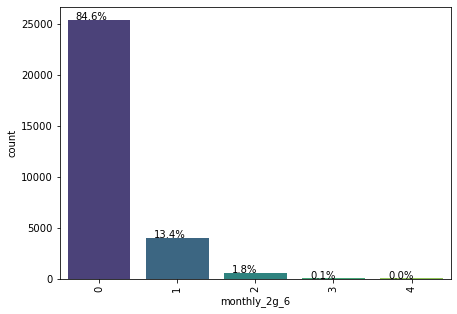

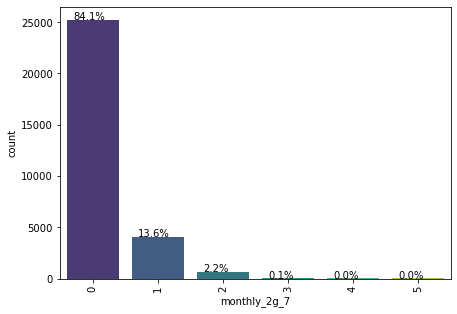

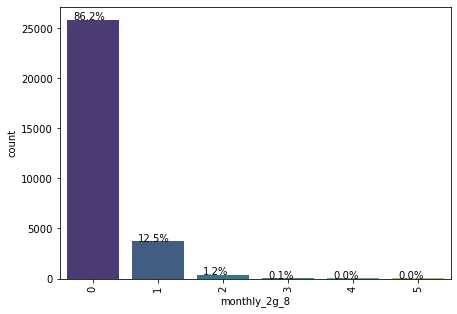

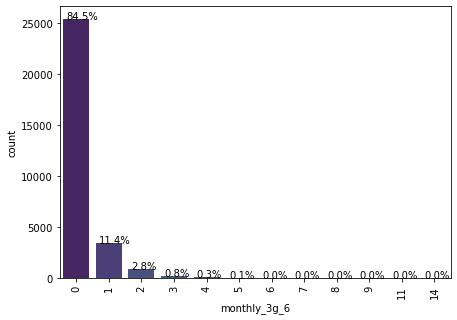

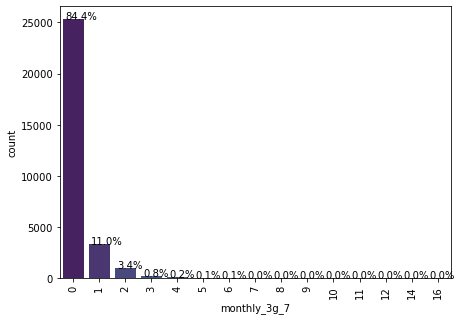

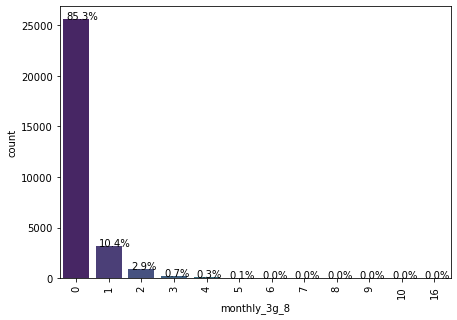

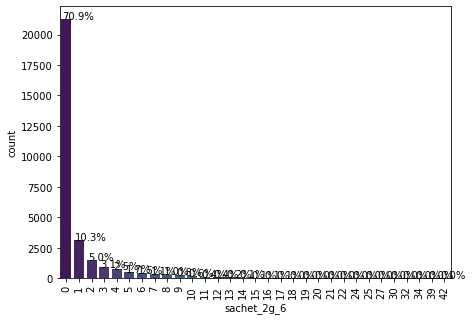

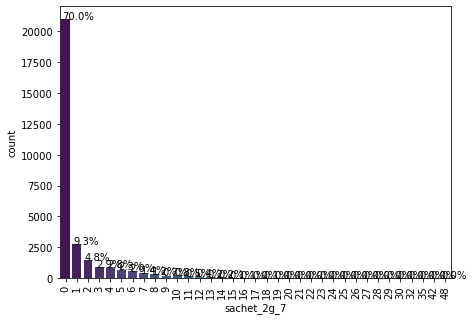

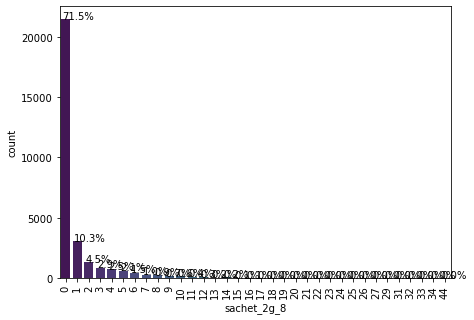

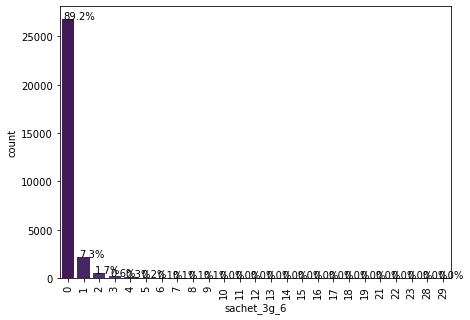

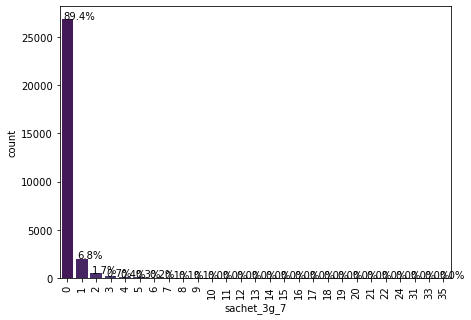

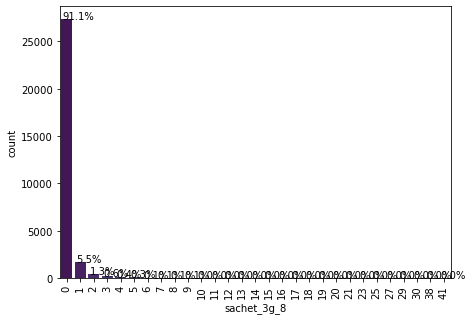

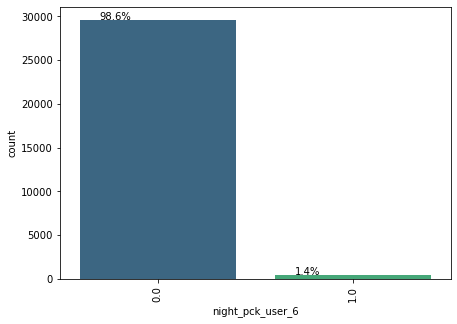

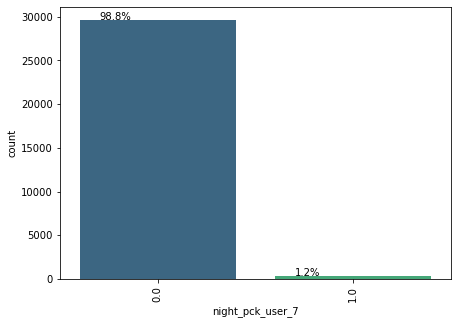

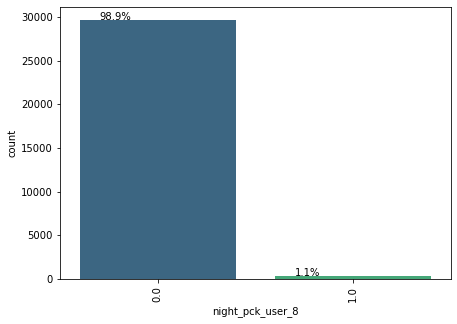

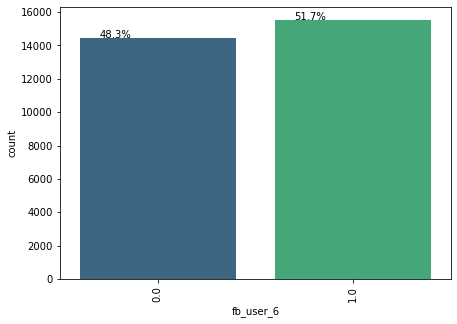

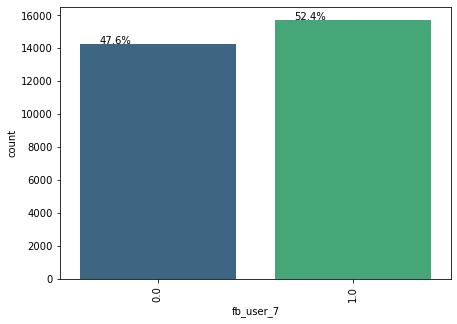

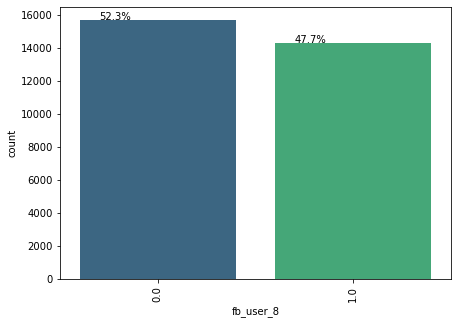

In [43]:
for item in categorical_features:
    univar_graph(df=telecom_churn,col=item,vartype=1, hue=None)

### Inferences
- 3g network does not have demand in the month of Jun, July and August.
- Similarly, 2g network also doesnt have demand for the same months. it has around 14% demand in Jun and July and around 13% in August.
- There are very a smaller number of users are for night pack schema for the month of Jun, July and August.

- There are most demand in Service scheme to avail services of Facebook and similar social networking sites in the month of Jun, Jul. and August. The percentage of demands are 96% in Jun and July and 95% in August.

- The following variables are high dominating variable having single category is more than 97%
    - night_pck_user_6
    - night_pck_user_7
    - night_pck_user_8
- There are many small small segments which we will group together and proceed with analysis.

## 4.1.3 Segrigate the smaller categories into one.

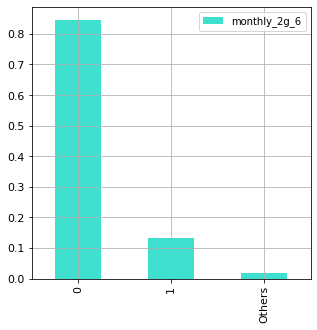

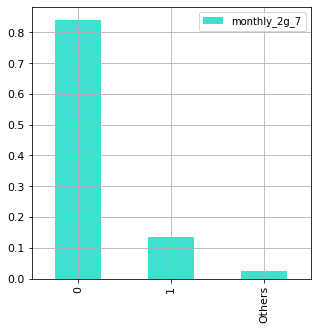

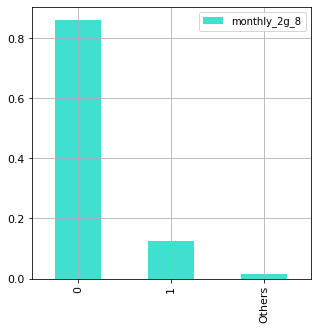

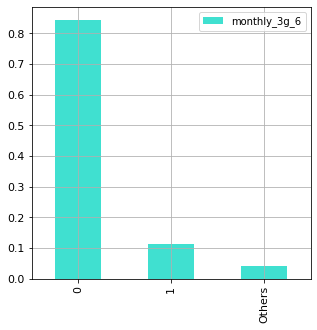

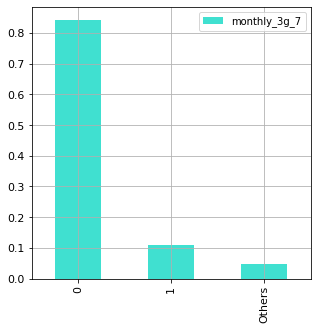

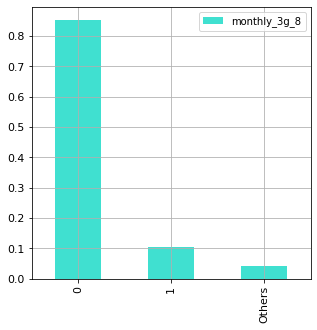

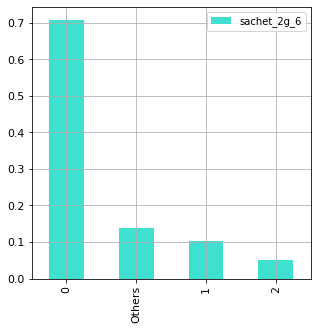

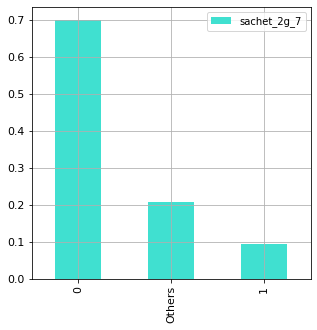

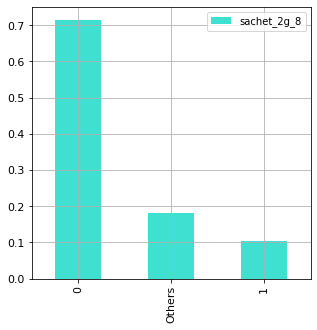

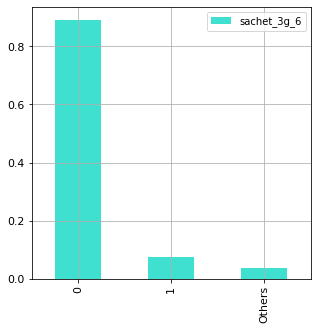

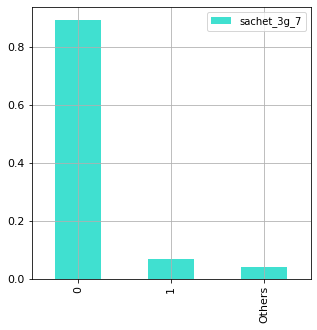

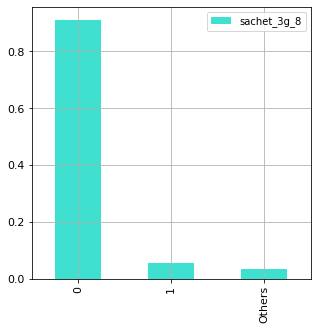

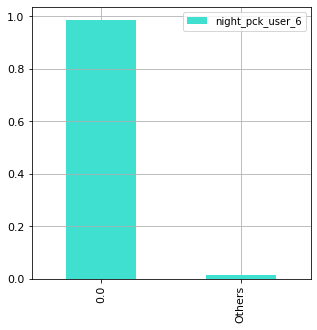

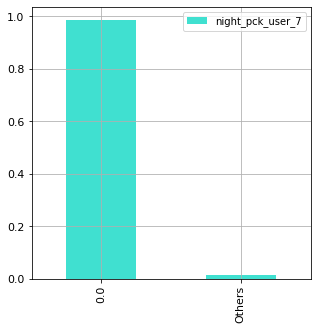

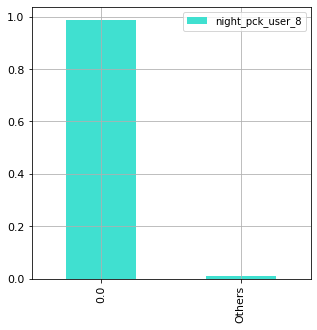

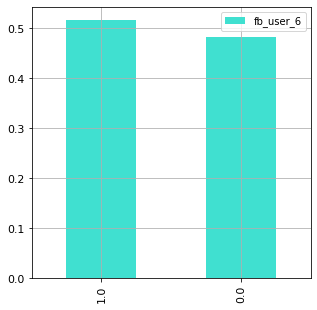

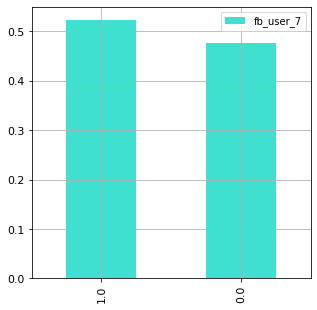

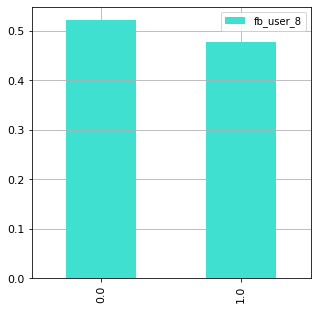

In [44]:
for val in categorical_features:
    Segrigate(val)

## Inferences 

- Categories which were having values less than 5% were grouped into one categories called **Others**

In [45]:
## Checking the datatype
telecom_churn[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   monthly_2g_6      30001 non-null  object
 1   monthly_2g_7      30001 non-null  object
 2   monthly_2g_8      30001 non-null  object
 3   monthly_3g_6      30001 non-null  object
 4   monthly_3g_7      30001 non-null  object
 5   monthly_3g_8      30001 non-null  object
 6   sachet_2g_6       30001 non-null  object
 7   sachet_2g_7       30001 non-null  object
 8   sachet_2g_8       30001 non-null  object
 9   sachet_3g_6       30001 non-null  object
 10  sachet_3g_7       30001 non-null  object
 11  sachet_3g_8       30001 non-null  object
 12  night_pck_user_6  30001 non-null  object
 13  night_pck_user_7  30001 non-null  object
 14  night_pck_user_8  30001 non-null  object
 15  fb_user_6         30001 non-null  object
 16  fb_user_7         30001 non-null  object
 17  fb_user_8   

### 4.1.4 Continuous features Analysis

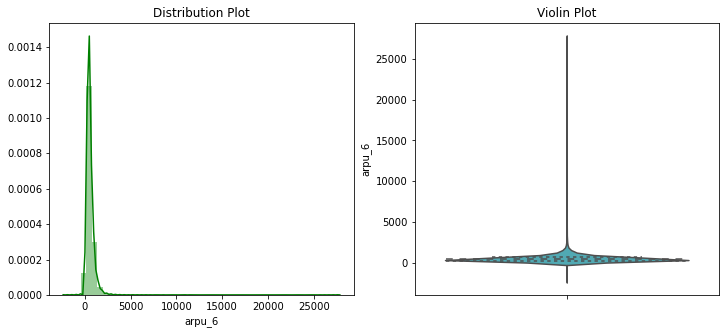

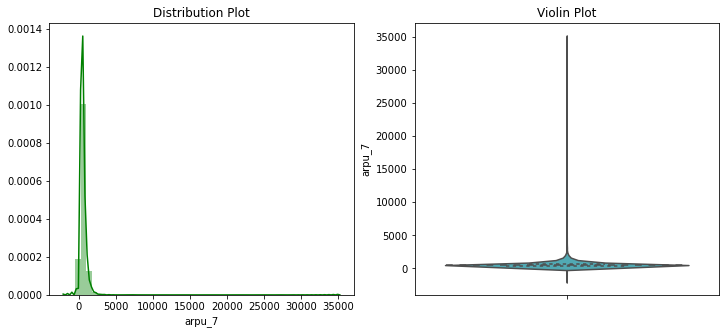

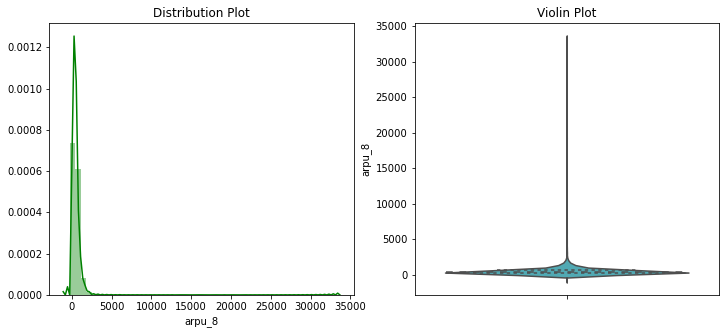

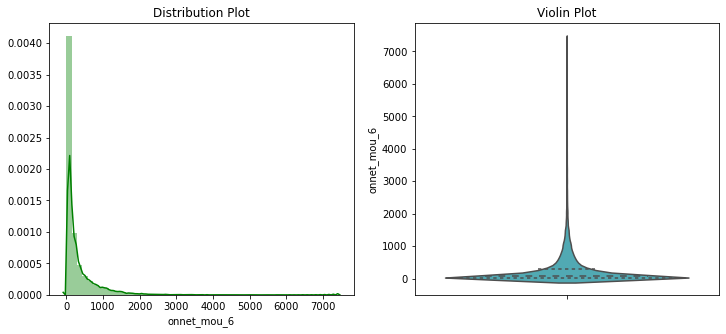

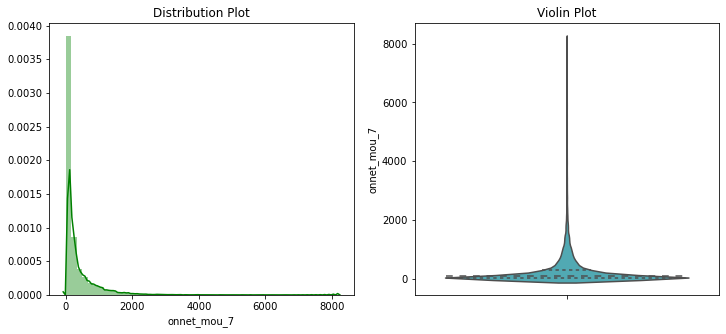

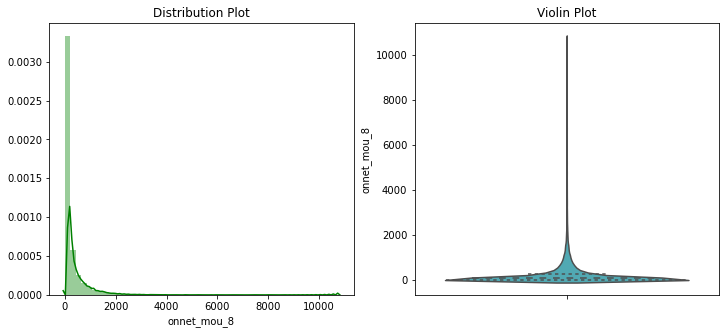

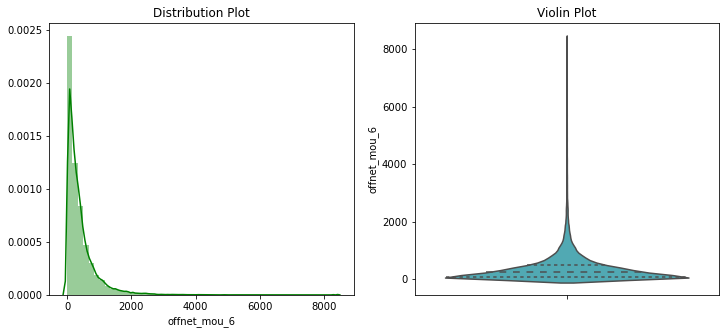

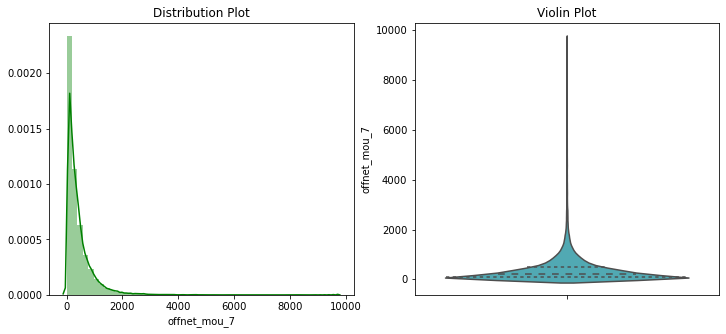

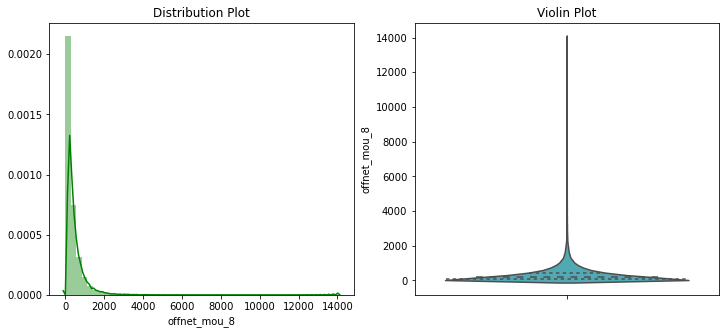

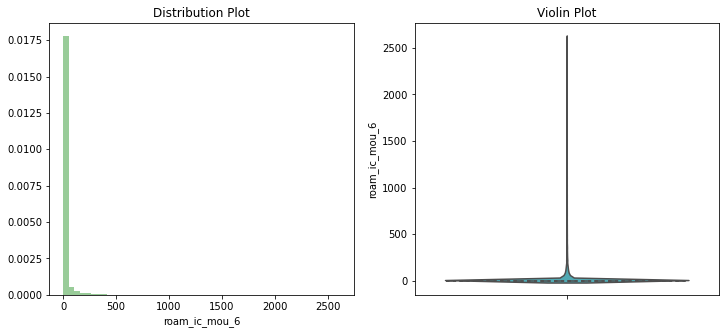

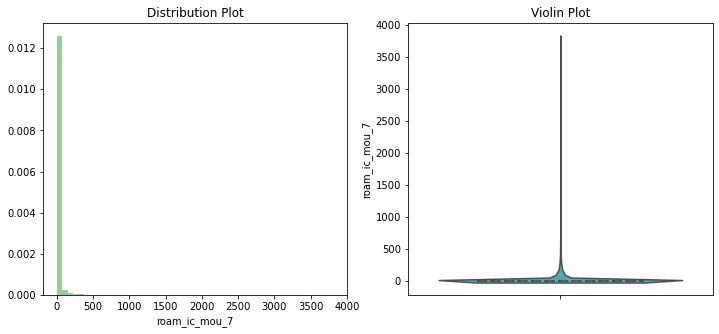

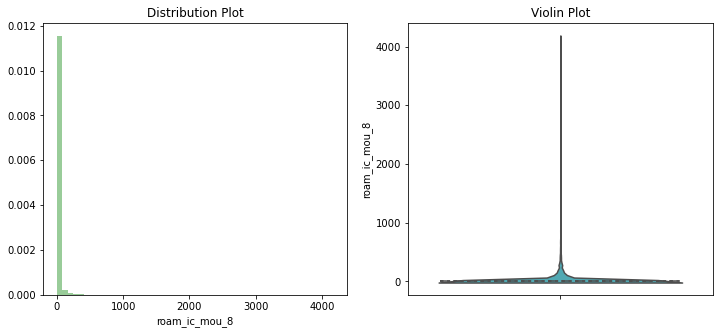

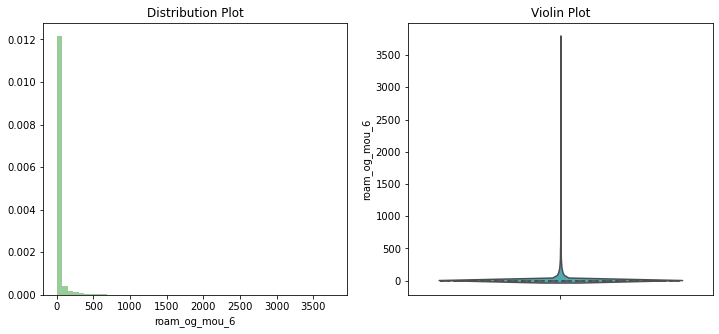

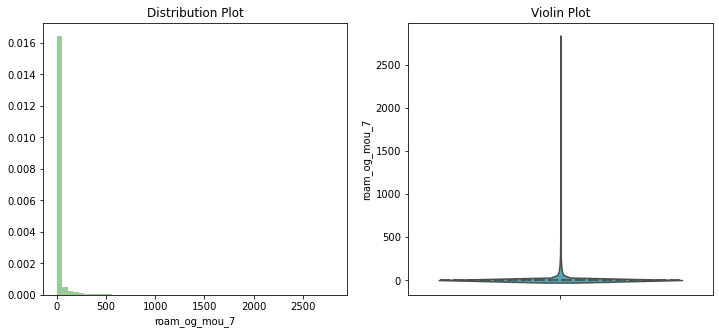

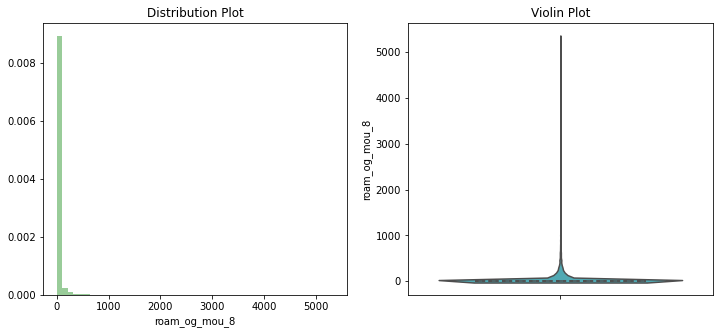

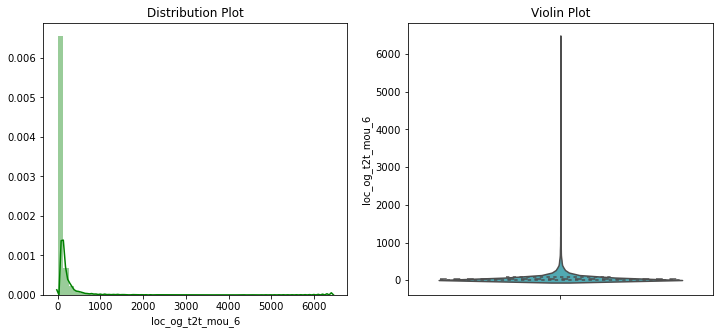

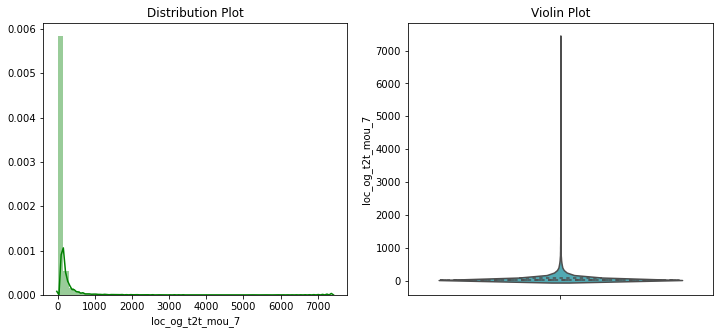

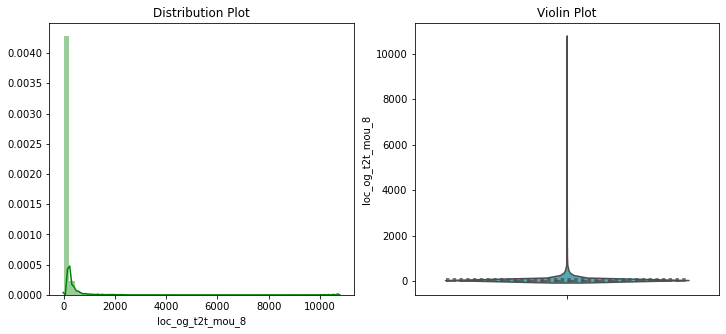

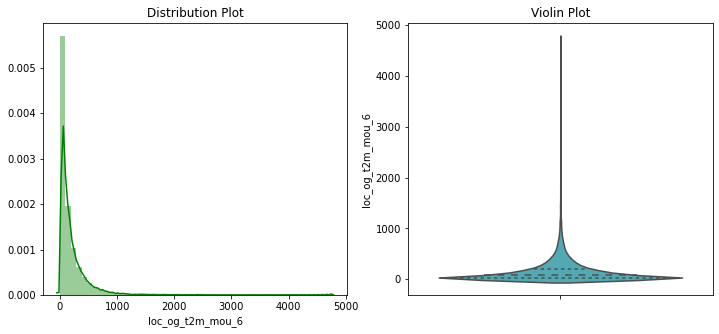

In [46]:
for item in numerical_features[1:20]:
    univar_graph(df=telecom_churn,col=item,vartype=0, hue=None)

## Inferences 

- Arpu_6,Arpu_7,Arpu_8 seems to having values <5000
- The highest value for Onnet_Mou kept incereasing from Jun to AUg
- Roam_ic_mou values seems to be below 1000 for all three months .

We will carry out Bivariate analysis in order to find more insights as well .

### 4.1.5 Target Variable Analysis

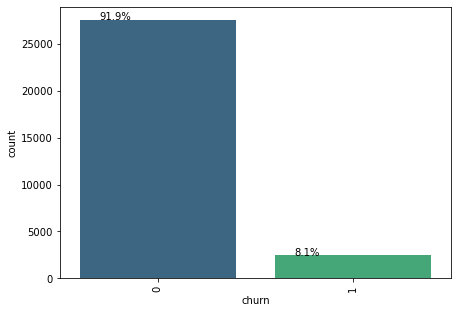

In [47]:
## Churn (Target Variable)
univar_graph(df=telecom_churn,col='churn',vartype=1, hue=None)

### Inferences

As we observed earlier, churn rate is low in the overall dataset(no Churn= 91.9%, Churn =8.1%) . So we would need to handle the class imbalance while or before modeling.

## 4.2 Bivariate Analysis

In [48]:
# create box plot for  6th, 7th and 8th month for Bivariate analysis
def plot_box_chart(attribute, vtitle):
    index=1
    mth = [6,7,8]
    mth = [attribute +"_"+str(ele) for ele in mth]
    fig = plt.figure(figsize=(12, 5))
    plt.rcParams['axes.titlesize'] = 14
    for vals in mth:
        ax = fig.add_subplot(1, 3, index)
        sns.boxplot(x='churn', y=vals, data=telecom_churn, hue="churn", showfliers=False,palette=("Accent"))
        plt.xlabel('Churn')
        plt.suptitle(vtitle, weight='bold')
        plt.tight_layout(pad=3.0)
        index= index+1

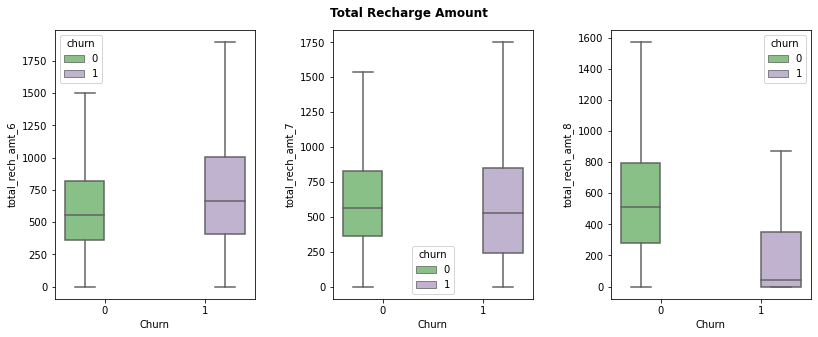

In [49]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt', 'Total Recharge Amount')

### Inferences

- The median recharge amount of Churned Customers has a huge dip in th month of August

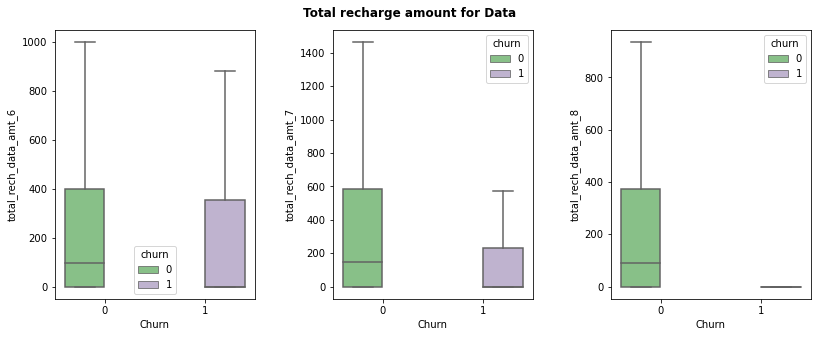

In [50]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_data_amt', 'Total recharge amount for Data')

## Inferences
- The Churned Customers didnt recharge Data in the month of August 
- Also they had Less Data recharge in the month of Jul.

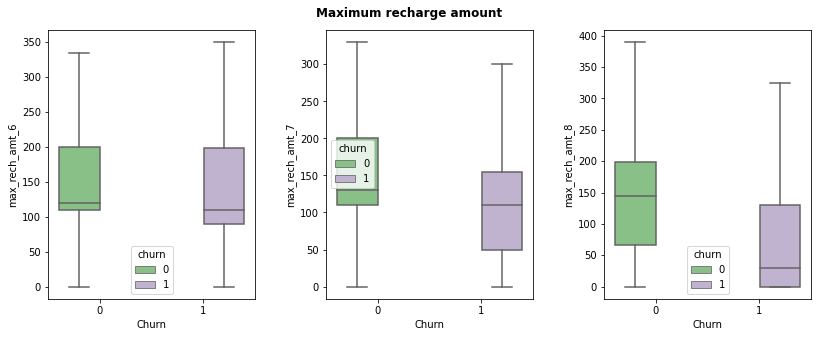

In [51]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt', 'Maximum recharge amount',)

## Inferences 

- The median of maximum recharge for Churners in the month of August is below 50

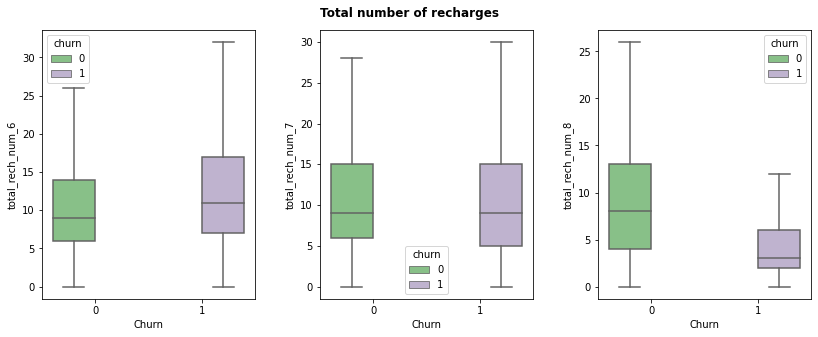

In [52]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num', 'Total number of recharges')

## Inferences 
- The median of total number of recharges decreased to less than 5 in the mont hof August for the Churned Customers  

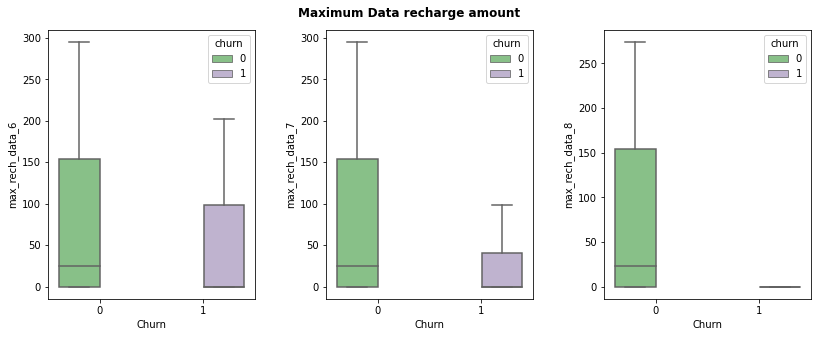

In [53]:
# Ploting for maximum recharge for data:
plot_box_chart('max_rech_data', 'Maximum Data recharge amount')

## Inferences 
- The median of Churners was 0 for all the 3 months

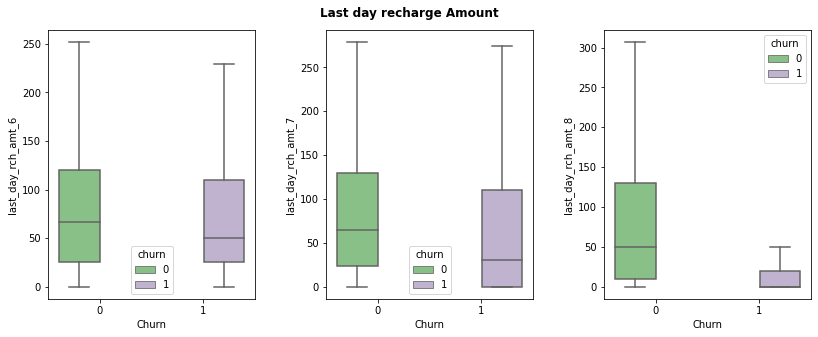

In [54]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt', 'Last day recharge Amount')

## Inferences
- The median of last day recharge amount of churners is low through out  Jun , Jul , August from the non churners

## 4.3 Multivariate Analysis

### 4.3.1 Average Revenue per User (Arpu)

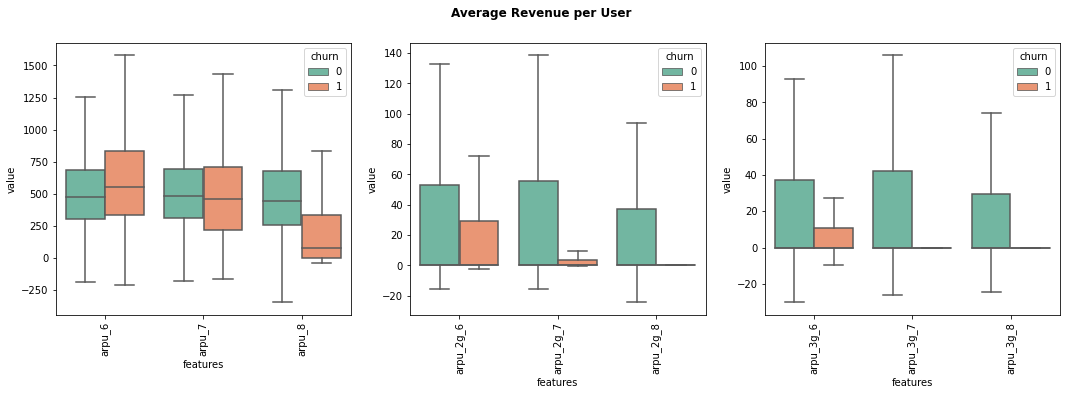

In [55]:
cols = [
        ['arpu_6','arpu_7','arpu_8'],
        ['arpu_2g_6','arpu_2g_7','arpu_2g_8'],
        ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
       ]

# plot for the arpu
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([telecom_churn[cols[i]], telecom_churn['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X, showfliers=False, palette=("Set2"));
    plt.xticks(rotation=90)    
    plt.suptitle('Average Revenue per User', weight='bold')

plt.show();
    

### Inferences 
- The median of average revenue per user kept on decreasing from Jun to Aug .
- Same is the case for 2g and 3g . ( we can see a drastic change in 2g,3g arpu from Jun to ju and Aug)

### 4.3.2 Plot Incoming Calls Usage

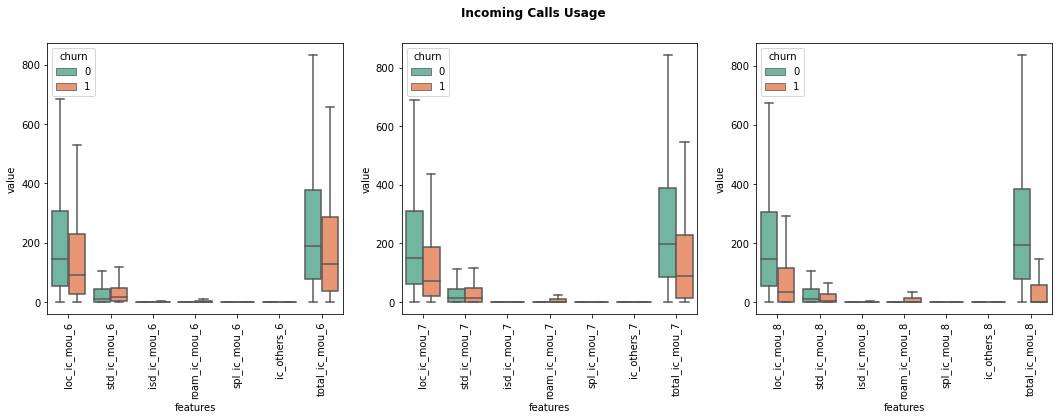

In [56]:
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([telecom_churn[cols[i]], telecom_churn['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X,showfliers=False, palette=("Set2"))
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage', weight='bold')
plt.show();

### Inferences
 - The median value of incoming call usage were more or less same in Jun and July and got decresed in August for Churned Customers.

### 4.3.3 Plot Outgoing Calls Usage

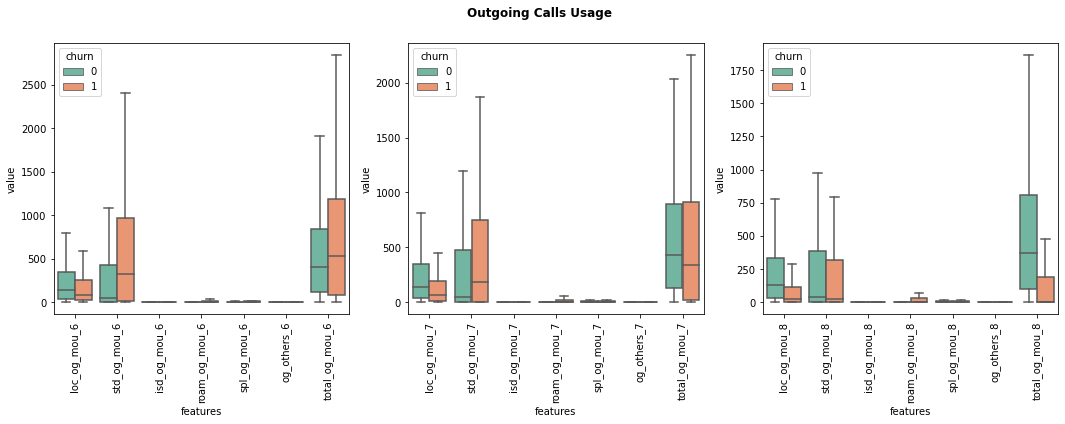

In [57]:
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([telecom_churn[cols[i]], telecom_churn['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X, showfliers=False, palette=("Set2"))
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage', weight='bold')
plt.show();

## Inferences 
- Outgoing calls follow the similar pattern as that of the Incoming calls .

### 4.3.4 Plot All Calls Usage

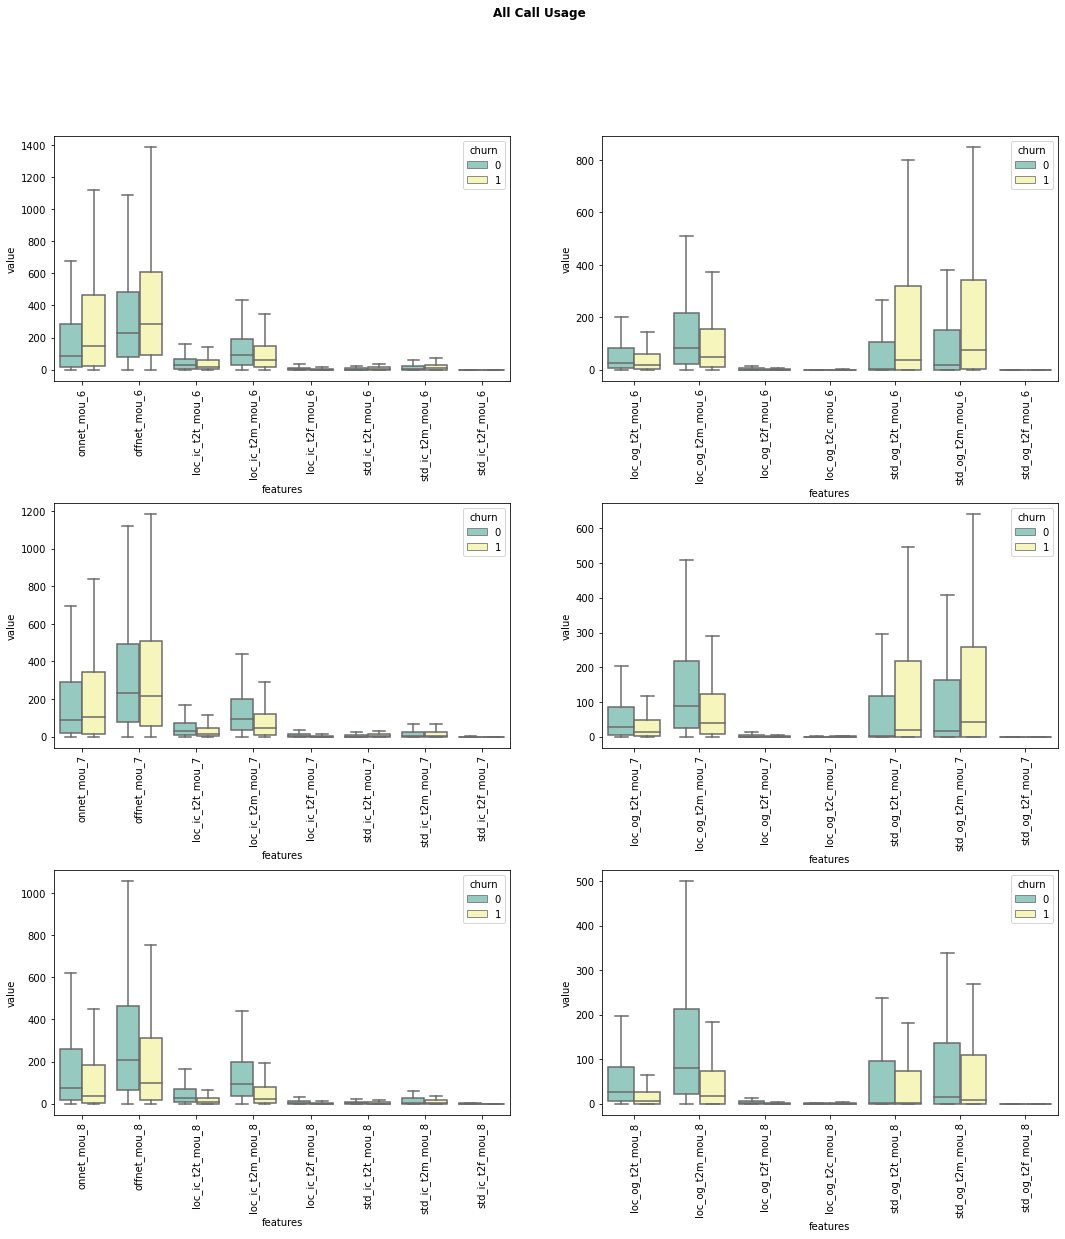

In [58]:
cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# plot for the all calls usage
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([telecom_churn[cols[i]], telecom_churn['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X, showfliers=False, palette=("Set3"))
    plt.xticks(rotation=90)    
    plt.suptitle('All Call Usage', weight='bold')
plt.show();

### Inferences 
- The median for the churned Customers kept on decresing from Jun to August for almost all features 

### 4.3.5 Plot Age on Network

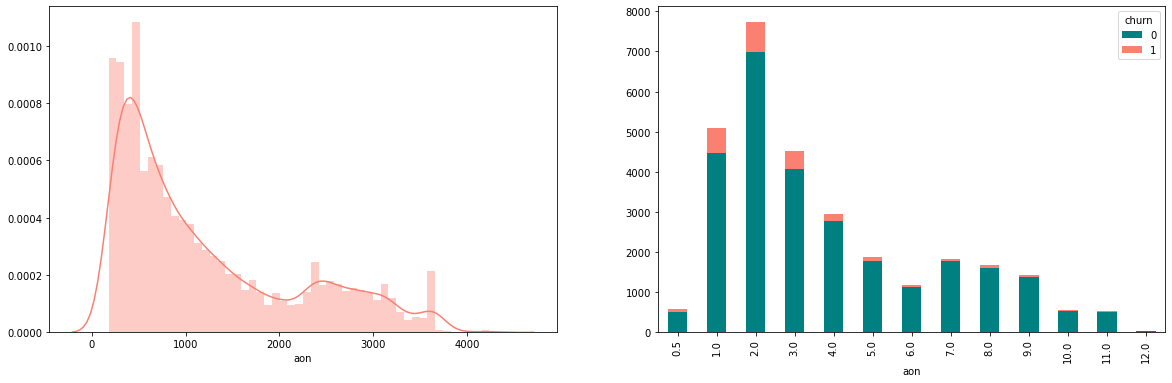

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(telecom_churn['aon'], ax=ax1,color='salmon')

# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
pd.crosstab(pd.cut(round(((telecom_churn['aon']/30)/12),1), bins = bins, labels = labels ), 
            telecom_churn['churn']).plot(kind='bar', stacked=True, ax = ax2,color=['teal','salmon'])
plt.show();

### Inferences 
- Most of the Churened customers were from the segment 1,2 and 3 and the churn rate decreased when it increased .


### 4.4. Plot for Multicolinearity check

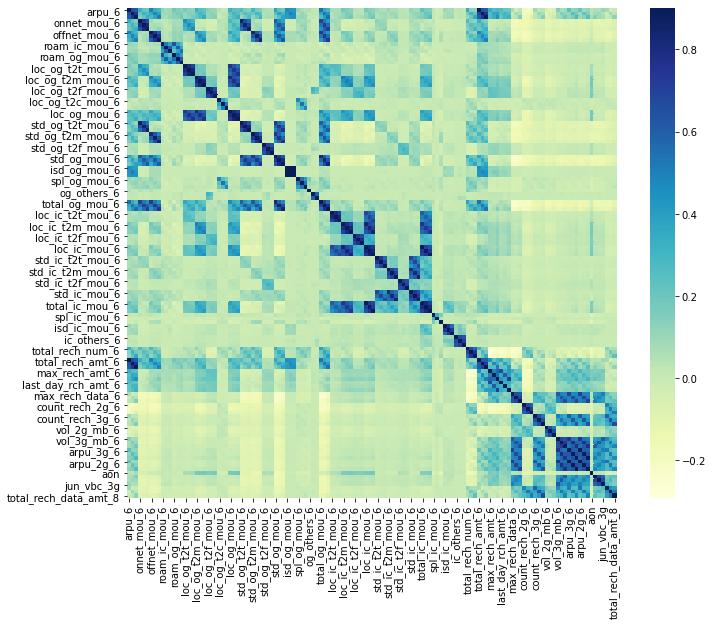

In [60]:
#correlation matrix
corrmat = telecom_churn[numerical_features[1:]].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9,cmap="YlGnBu", square=True);

In [61]:
# Threshold for removing correlated variables
threshold = 0.7

# Absolute value correlation matrix
corr_matrix = telecom_churn[numerical_features[1:]].corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['arpu_8',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_7',
 'offnet_mou_8',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'isd_ic_mou_7',
 'isd_ic

we are not dropping these variables, lets RFE perform feature selection and PCA perform the feature selection,dimentionality reduction.

#### Determine dominating features over 97%

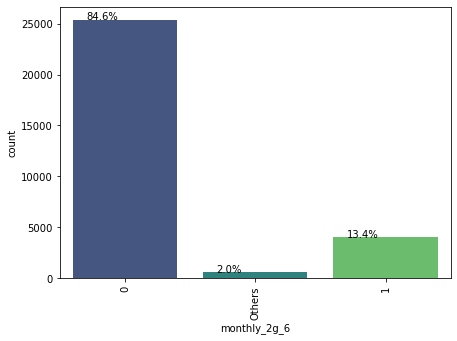

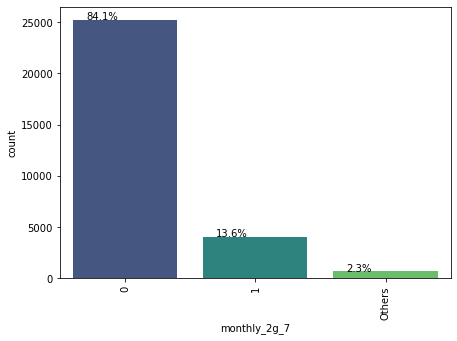

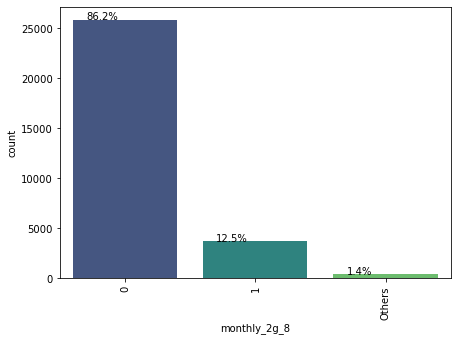

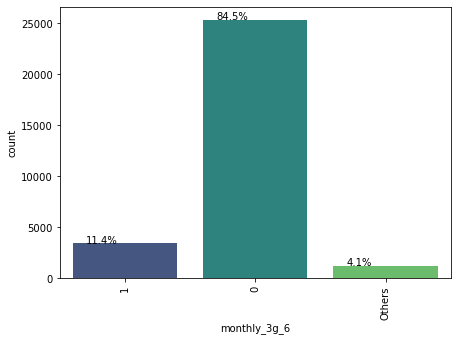

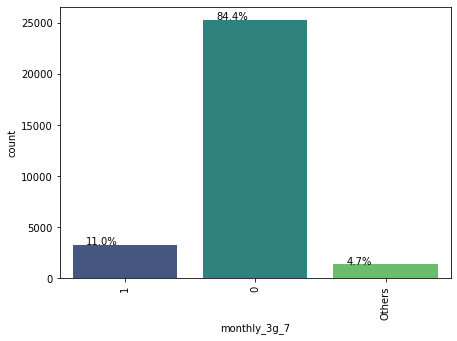

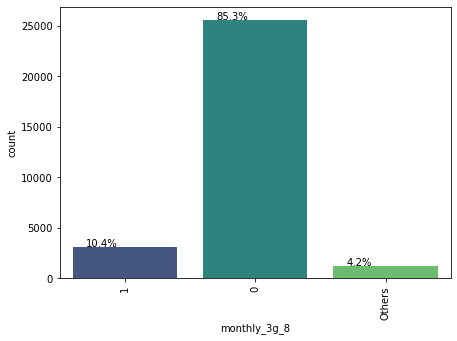

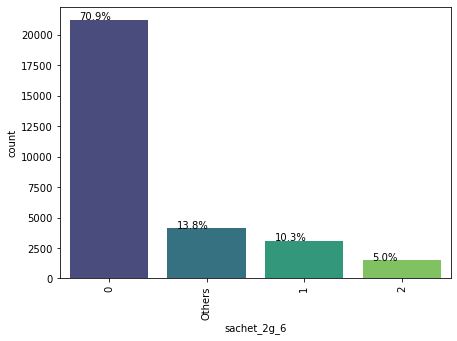

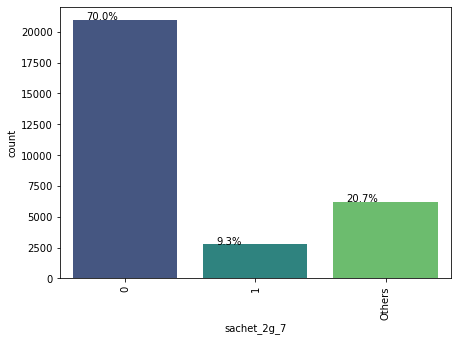

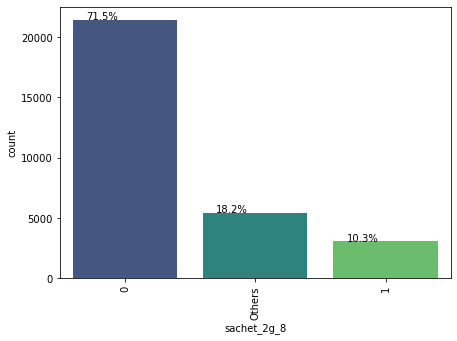

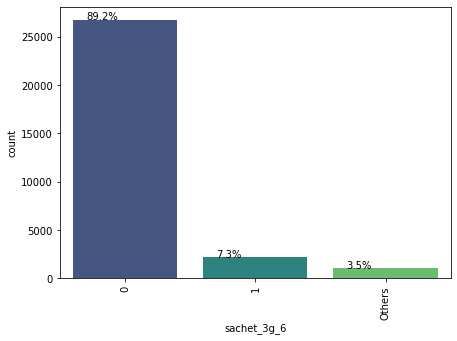

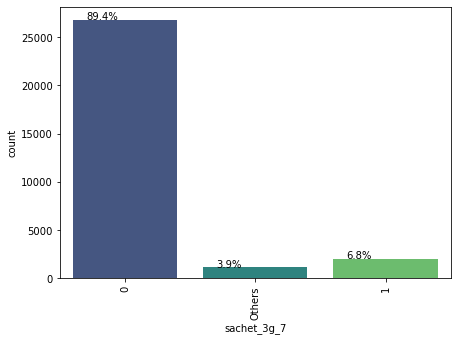

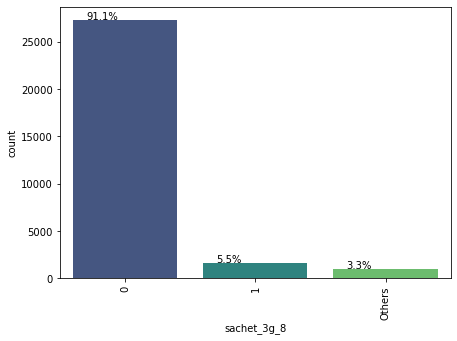

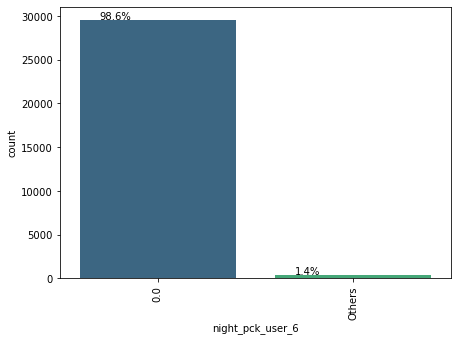

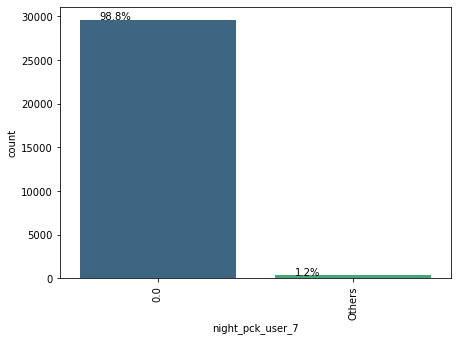

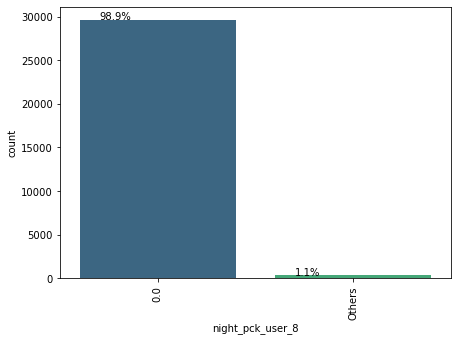

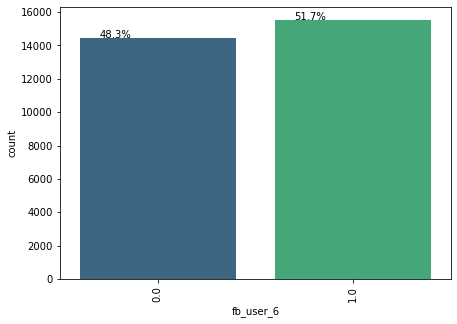

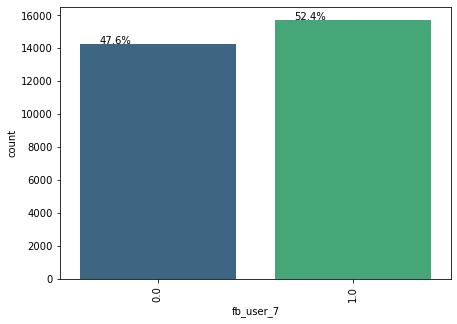

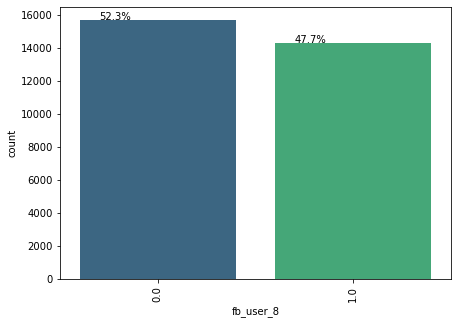

In [62]:
for cols in categorical_features:
    univar_graph(df=telecom_churn,col=cols,vartype=1, hue=None)

### Inferences
- The following variables are high dominating variable having single category is more than 97%
    - night_pck_user_6
    - night_pck_user_7
    - night_pck_user_8


In [63]:
# Remove from the numerical_features list.
#numerical_features = [i for i in numerical_features if i not in to_drop]

In [64]:
telecom_churn.shape

(30001, 156)

## 5. Data Preparation - Creating derived Variables 

In this section we will proceed with creating Derived Variables 

### 5.1 User defined function to create Derived features

In [65]:
def derived_features(col, option):
    '''
    This function will create 3 columns in which  one column would have minimum value , 2nd one will create the 
    Column with maximum value and third will get the average value for each user/phone number 
    '''
    mth = [6,7,8]
    mth = [col +"_"+str(ele) for ele in mth]
    if option ==0:
        #Minimum
        col1 = 'min_'+str(col)
        telecom_churn[col1] = round(telecom_churn[mth].min(axis=1),2)
    elif option ==1:
        #Mean
        col1 = 'max_'+str(col)
        telecom_churn[col1] = round(telecom_churn[mth].max(axis=1),2)
    else:
        #Maximum
        col1 = 'mean_'+str(col)
        telecom_churn[col1] = round(telecom_churn[mth].mean(axis=1),2)
    print(col1)

### 5.2 Derived column(min/max/mean) creation for amount/recharge/data related columns 

In [66]:
# Let us first extract list of columns containing recharge amount
telecom_churn.columns[telecom_churn.columns.str.contains('rech_amt|rech_data')]

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'total_rech_data_amt_6', 'total_rech_data_amt_7',
       'total_rech_data_amt_8'],
      dtype='object')

In [67]:
# Total recharge number min, max & mean.
derived_features('total_rech_num',0), derived_features('total_rech_num',1), derived_features('total_rech_num',2)

# total_rech_amt columns
derived_features('total_rech_amt',0), derived_features('total_rech_amt',1), derived_features('total_rech_amt',2)

# mean max_rech_data columns
derived_features('max_rech_data',1)

# mean max_rech_amt columns
derived_features('max_rech_amt',1)

# mean last_day_rch_amt columns
derived_features('last_day_rch_amt',1)

# total_rech_amt_data columns
derived_features('total_rech_data_amt',0), derived_features('total_rech_data_amt',1), derived_features('total_rech_data_amt',2)

min_total_rech_num
max_total_rech_num
mean_total_rech_num


(None, None, None)

min_total_rech_amt
max_total_rech_amt
mean_total_rech_amt


(None, None, None)

max_max_rech_data
max_max_rech_amt
max_last_day_rch_amt
min_total_rech_data_amt
max_total_rech_data_amt
mean_total_rech_data_amt


(None, None, None)

### 5.3 Creating derived columns for ARPU ( min/max/mean column creation for each user )

In [68]:
# ARPU min, max & mean.
derived_features('arpu',0), derived_features('arpu',1), derived_features('arpu',2)
derived_features('arpu_2g',0), derived_features('arpu_2g',1), derived_features('arpu_2g',2)
derived_features('arpu_3g',0), derived_features('arpu_3g',1), derived_features('arpu_3g',2)
derived_features('vol_2g_mb',0), derived_features('vol_2g_mb',1), derived_features('vol_2g_mb',2)
derived_features('vol_3g_mb',0), derived_features('vol_3g_mb',1), derived_features('vol_3g_mb',2)

min_arpu
max_arpu
mean_arpu


(None, None, None)

min_arpu_2g
max_arpu_2g
mean_arpu_2g


(None, None, None)

min_arpu_3g
max_arpu_3g
mean_arpu_3g


(None, None, None)

min_vol_2g_mb
max_vol_2g_mb
mean_vol_2g_mb


(None, None, None)

min_vol_3g_mb
max_vol_3g_mb
mean_vol_3g_mb


(None, None, None)

### 5.4 Creating derived columns for Call usage ( ( min/max/mean column creation for each user)

In [69]:
# mean of onnet and offnet mou
derived_features('onnet_mou',2)
derived_features('offnet_mou',2)

# mean of roam_ic_mou & roam_og_mou
derived_features('roam_ic_mou',2)
derived_features('roam_og_mou',2)

# mean of loc_ic_t2t_mou & loc_og_t2t_mou
derived_features('loc_ic_t2t_mou',2)
derived_features('loc_og_t2t_mou',2)

# mean of loc_ic_t2m_mou, loc_og_t2m_mou
derived_features('loc_ic_t2m_mou',2)
derived_features('loc_og_t2m_mou',2)

# mean local t2f columns
derived_features('loc_ic_t2f_mou',2)
derived_features('loc_og_t2f_mou',2)

# mean std-t2t columns
derived_features('std_ic_t2t_mou',2)
derived_features('std_og_t2t_mou',2)

# mean std-t2m columns
derived_features('std_ic_t2m_mou',2)
derived_features('std_og_t2m_mou',2)

# mean std-t2f columns
derived_features('std_ic_t2f_mou',2)
derived_features('std_og_t2f_mou',2)

# mean loc columns
derived_features('loc_ic_mou',2)
derived_features('loc_og_mou',2)

# mean std columns
derived_features('std_ic_mou',2)
derived_features('std_og_mou',2)

# mean isd columns
derived_features('isd_ic_mou',2)
derived_features('isd_og_mou',2)

mean_onnet_mou
mean_offnet_mou
mean_roam_ic_mou
mean_roam_og_mou
mean_loc_ic_t2t_mou
mean_loc_og_t2t_mou
mean_loc_ic_t2m_mou
mean_loc_og_t2m_mou
mean_loc_ic_t2f_mou
mean_loc_og_t2f_mou
mean_std_ic_t2t_mou
mean_std_og_t2t_mou
mean_std_ic_t2m_mou
mean_std_og_t2m_mou
mean_std_ic_t2f_mou
mean_std_og_t2f_mou
mean_loc_ic_mou
mean_loc_og_mou
mean_std_ic_mou
mean_std_og_mou
mean_isd_ic_mou
mean_isd_og_mou


### 5.5 Creating more derived columns for finding insights on the incoming and out going calls 

In [70]:
telecom_churn['diff_ic_og_6'] = telecom_churn['total_ic_mou_6']-telecom_churn['total_og_mou_6']
telecom_churn['diff_ic_og_7'] = telecom_churn['total_ic_mou_7']-telecom_churn['total_og_mou_7']
telecom_churn['diff_ic_og_8'] = telecom_churn['total_ic_mou_8']-telecom_churn['total_og_mou_8']

telecom_churn['diff_vol_3g_2g_6'] = telecom_churn['vol_3g_mb_6']-telecom_churn['vol_2g_mb_6']
telecom_churn['diff_vol_3g_2g_7'] = telecom_churn['vol_3g_mb_7']-telecom_churn['vol_2g_mb_7']
telecom_churn['diff_vol_3g_2g_8'] = telecom_churn['vol_3g_mb_8']-telecom_churn['vol_2g_mb_8']

telecom_churn['diff_ic_good_active_phase']=telecom_churn['total_ic_mou_6']+telecom_churn['total_ic_mou_7']-telecom_churn['total_ic_mou_8']
telecom_churn['diff_og_good_active_phase']=telecom_churn['total_og_mou_6']+telecom_churn['total_og_mou_7']-telecom_churn['total_og_mou_8']
telecom_churn['diff_2g_good_active_phase']=telecom_churn['vol_2g_mb_6']+telecom_churn['vol_2g_mb_7']-telecom_churn['vol_2g_mb_8']
telecom_churn['diff_3g_good_active_phase']=telecom_churn['vol_3g_mb_6']+telecom_churn['vol_3g_mb_7']-telecom_churn['vol_3g_mb_8']

### 5.6 Fixing the Date columns

In [71]:
cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
# get the recent date of recharge in the last 3 months
telecom_churn['last_rech_date'] = telecom_churn[cols].max(axis=1)
# get the number of days from the recent recharge date till the last date of august month
telecom_churn['days_since_last_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - telecom_churn['last_rech_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
telecom_churn['days_since_last_rech'] = telecom_churn['days_since_last_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3,  means present in all columns, 0 means not present in any column
telecom_churn['rech_weightage'] = len(cols) - (telecom_churn[cols].isnull().sum(axis=1))
telecom_churn.drop(['last_rech_date','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)


cols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
# get the recent date of recharge data in the last 3 months
telecom_churn['last_rech_data_date'] = telecom_churn[cols].max(axis=1)
# get the number of days from the recent recharge data date till the last date of august month
telecom_churn['days_since_last_data_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - telecom_churn['last_rech_data_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
telecom_churn['days_since_last_data_rech'] = telecom_churn['days_since_last_data_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3, means present in all columns, 0 means not present in any column
telecom_churn['rech_data_weightage'] = len(cols) - (telecom_churn[cols].isnull().sum(axis=1))



### 5.7 Drop the unwanted columns which were used to create Derived Columns

In [72]:
# drop the unwanted columns
telecom_churn.drop(['last_rech_data_date','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

In [73]:
## Inpecting the latest Dataset 
telecom_churn.head()
telecom_churn.shape

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,churn,min_total_rech_num,max_total_rech_num,mean_total_rech_num,min_total_rech_amt,max_total_rech_amt,mean_total_rech_amt,max_max_rech_data,max_max_rech_amt,max_last_day_rch_amt,min_total_rech_data_amt,max_total_rech_data_amt,mean_total_rech_data_amt,min_arpu,max_arpu,mean_arpu,min_arpu_2g,max_arpu_2g,mean_arpu_2g,min_arpu_3g,max_arpu_3g,mean_arpu_3g,min_vol_2g_mb,max_vol_2g_mb,mean_vol_2g_mb,min_vol_3g_mb,max_vol_3g_mb,mean_vol_3g_mb,mean_onnet_mou,mean_offnet_mou,mean_roam_ic_mou,mean_roam_og_mou,mean_loc_ic_t2t_mou,mean_loc_og_t2t_mou,mean_loc_ic_t2m_mou,mean_loc_og_t2m_mou,mean_loc_ic_t2f_mou,mean_loc_og_t2f_mou,mean_std_ic_t2t_mou,mean_std_og_t2t_mou,mean_std_ic_t2m_mou,mean_std_og_t2m_mou,mean_std_ic_t2f_mou,mean_std_og_t2f_mou,mean_loc_ic_mou,mean_loc_og_mou,mean_std_ic_mou,mean_std_og_mou,mean_isd_ic_mou,mean_isd_og_mou,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,days_since_last_rech,rech_weightage,days_since_last_data_rech,rech_data_weightage
0,7000842753,197.385,214.816,213.803,0.402,0.00,0.00,2.176,2.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.402,0.00,0.00,1.098,0.106,0.00,0.00,0.07,0.00,1.078,0.566,0.00,1.50,0.176,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,1.12,2.752,0.00,0.248,0.0,0.0,0.00,0.00,0.00,2.764,1.53,0.16,2.986,6.252,4.13,1.452,0.386,1.15,7.204,8.17,5.44,0.632,0.00,0.00,6.856,2.85,0.00,0.00,0.00,0.00,7.488,2.85,0.00,0.00,0.00,5.44,0.026,0.04,0.0,0.062,0.00,0.00,0.472,0.036,0.00,4,3,2,362,252,252,252,252,252,252,252,252,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,968,30.40,0.00,101.20,252.0,252.0,252.0,1,2,4,3.0

(30001, 213)

In [74]:
## List of numerical_features
numerical_features = telecom_churn.select_dtypes(exclude = ["object", 'datetime64[ns]']).columns
numerical_features=numerical_features.drop('churn')
numerical_features = numerical_features.values.tolist()
len(numerical_features)

194

## 6. Outlier Treatment

#### Cap the outliers at the top percentile

We'll need to cap the outliers at the 99th percentile for the below columns.

In [75]:
telecom_churn[numerical_features[1:]].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,min_total_rech_num,max_total_rech_num,mean_total_rech_num,min_total_rech_amt,max_total_rech_amt,mean_total_rech_amt,max_max_rech_data,max_max_rech_amt,max_last_day_rch_amt,min_total_rech_data_amt,max_total_rech_data_amt,mean_total_rech_data_amt,min_arpu,max_arpu,mean_arpu,min_arpu_2g,max_arpu_2g,mean_arpu_2g,min_arpu_3g,max_arpu_3g,mean_arpu_3g,min_vol_2g_mb,max_vol_2g_mb,mean_vol_2g_mb,min_vol_3g_mb,max_vol_3g_mb,mean_vol_3g_mb,mean_onnet_mou,mean_offnet_mou,mean_roam_ic_mou,mean_roam_og_mou,mean_loc_ic_t2t_mou,mean_loc_og_t2t_mou,mean_loc_ic_t2m_mou,mean_loc_og_t2m_mou,mean_loc_ic_t2f_mou,mean_loc_og_t2f_mou,mean_std_ic_t2t_mou,mean_std_og_t2t_mou,mean_std_ic_t2m_mou,mean_std_og_t2m_mou,mean_std_ic_t2f_mou,mean_std_og_t2f_mou,mean_loc_ic_mou,mean_loc_og_mou,mean_std_ic_mou,mean_std_og_mou,mean_isd_ic_mou,mean_isd_og_mou,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,days_since_last_rech,rech_weightage,days_since_last_data_rech,rech_data_weightage
count,30001.000000,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000

#### Capping Ranges:
- 1st - 99th percentile -  Soft range.
- 5th - 95th percentile -> Medium range.
- 25th- 75th percentile -> Hard range.

In [76]:
cols_to_exclude = ['mobile_number','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6',
                   'spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8','loc_og_t2c_mou_6','std_og_t2f_mou_6',
                   'std_ic_t2f_mou_6','loc_ic_t2f_mou_6','loc_og_t2c_mou_7','std_og_t2f_mou_7',
                   'std_ic_t2f_mou_7','loc_ic_t2f_mou_7','loc_og_t2c_mou_8','std_og_t2f_mou_8',
                   'std_ic_t2f_mou_8','loc_ic_t2f_mou_8','aon']

cols = list(set(numerical_features).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = telecom_churn[col].quantile([0.01,0.99]).values
    telecom_churn[col][telecom_churn[col] >= percentiles[1]] = percentiles[1]

In [77]:
telecom_churn[cols].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,total_rech_data_amt_6,offnet_mou_8,loc_og_t2t_mou_7,min_arpu_3g,diff_2g_good_active_phase,mean_total_rech_amt,mean_std_ic_t2f_mou,diff_vol_3g_2g_8,loc_og_t2m_mou_7,loc_og_mou_6,isd_ic_mou_8,mean_offnet_mou,mean_loc_ic_t2f_mou,total_rech_num_6,std_og_mou_8,min_total_rech_num,vol_2g_mb_7,std_ic_t2m_mou_6,max_last_day_rch_amt,days_since_last_rech,roam_ic_mou_8,std_og_t2m_mou_7,arpu_2g_7,isd_og_mou_6,total_ic_mou_6,diff_og_good_active_phase,roam_og_mou_7,max_rech_data_8,loc_ic_t2t_mou_8,total_rech_num_7,mean_std_ic_mou,count_rech_3g_8,arpu_8,total_og_mou_8,max_arpu_3g,max_total_rech_data_amt,arpu_3g_7,std_og_t2m_mou_8,vol_3g_mb_7,std_og_t2t_mou_8,max_vol_2g_mb,ic_others_6,count_rech_2g_8,count_rech_3g_7,total_rech_data_amt_7,total_og_mou_7,max_arpu,mean_arpu_3g,std_og_mou_6,std_ic_t2m_mou_7,loc_og_mou_8,isd_og_mou_8,std_ic_mou_8,jul_vbc_3g,diff_ic_og_8,mean_loc_ic_t2m_mou,onnet_mou_8,arpu_3g_8,loc_og_t2m_mou_8,max_rech_data_7,vol_3g_mb_8,loc_ic_mou_6,min_total_rech_amt,std_ic_t2t_mou_6,onnet_mou_6,isd_ic_mou_6,rech_data_weightage,loc_ic_t2t_mou_6,ic_others_8,total_ic_mou_7,total_rech_amt_7,diff_ic_og_6,total_rech_amt_6,diff_vol_3g_2g_7,std_ic_t2t_mou_7,max_total_rech_amt,loc_ic_t2m_mou_7,mean_total_rech_data_amt,std_ic_mou_7,mean_loc_ic_t2t_mou,total_rech_amt_8,loc_og_mou_7,count_rech_3g_6,last_day_rch_amt_6,loc_ic_t2m_mou_8,loc_ic_mou_8,max_rech_data_6,total_rech_data_amt_8,std_og_mou_7,offnet_mou_7,max_rech_amt_7,diff_ic_og_7,min_vol_2g_mb,mean_vol_2g_mb,diff_vol_3g_2g_6,loc_og_t2f_mou_8,days_since_last_data_rech,mean_arpu,arpu_3g_6,loc_og_t2t_mou_8,max_arpu_2g,mean_std_og_t2t_mou,last_day_rch_amt_7,min_arpu,std_ic_mou_6,rech_weightage,vol_2g_mb_8,mean_std_ic_t2t_mou,max_total_rech_num,loc_og_t2f_mou_6,std_og_t2t_mou_7,arpu_2g_6,std_ic_t2t_mou_8,loc_ic_t2m_mou_6,count_rech_2g_6,mean_vol_3g_mb,mean_loc_og_t2t_mou,max_vol_3g_mb,roam_og_mou_8,isd_ic_mou_7,arpu_6,last_day_rch_amt_8,max_max_rech_data,mean_std_og_t2f_mou,std_og_t2m_mou_6,onnet_mou_7,aug_vbc_3g,mean_total_rech_num,mean_isd_og_mou,max_max_rech_amt,mean_loc_og_t2f_mou,mean_arpu_2g,total_og_mou_6,mean_std_ic_t2m_mou,max_rech_amt_8,min_vol_3g_mb,diff_3g_good_active_phase,roam_ic_mou_6,total_rech_num_8,loc_og_t2m_mou_6,arpu_2g_8,loc_ic_t2t_mou_7,mean_loc_ic_mou,arpu_7,mean_std_og_t2m_mou,max_rech_amt_6,std_og_t2t_mou_6,jun_vbc_3g,std_ic_t2m_mou_8,loc_og_t2t_mou_6,mean_roam_og_mou,mean_roam_ic_mou,roam_ic_mou_7,loc_og_t2f_mou_7,vol_3g_mb_6,offnet_mou_6,mean_onnet_mou,diff_ic_good_active_phase,isd_og_mou_7,mean_loc_og_t2m_mou,mean_std_og_mou,min_total_rech_data_amt,mean_isd_ic_mou,ic_others_7,count_rech_2g_7,roam_og_mou_6,vol_2g_mb_6,min_arpu_2g,mean_loc_og_mou,total_ic_mou_8,loc_ic_mou_7
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.

In [78]:
for i in numerical_features[1:]:
    print("--- "+i+" ---")
    print("Skewness: %f" % telecom_churn[i].skew())
    print("Kurtosis: %f" % telecom_churn[i].kurt())

--- arpu_6 ---
Skewness: 1.400728
Kurtosis: 3.063288
--- arpu_7 ---
Skewness: 1.437296
Kurtosis: 3.083730
--- arpu_8 ---
Skewness: 1.401160
Kurtosis: 2.569015
--- onnet_mou_6 ---
Skewness: 2.583294
Kurtosis: 7.179821
--- onnet_mou_7 ---
Skewness: 2.570672
Kurtosis: 7.016007
--- onnet_mou_8 ---
Skewness: 2.844096
Kurtosis: 8.815806
--- offnet_mou_6 ---
Skewness: 2.195282
Kurtosis: 5.632577
--- offnet_mou_7 ---
Skewness: 2.218774
Kurtosis: 5.828824
--- offnet_mou_8 ---
Skewness: 2.231285
Kurtosis: 5.797823
--- roam_ic_mou_6 ---
Skewness: 4.946631
Kurtosis: 26.205417
--- roam_ic_mou_7 ---
Skewness: 5.371811
Kurtosis: 30.739519
--- roam_ic_mou_8 ---
Skewness: 5.339761
Kurtosis: 30.422681
--- roam_og_mou_6 ---
Skewness: 4.673268
Kurtosis: 23.259967
--- roam_og_mou_7 ---
Skewness: 5.013530
Kurtosis: 26.814047
--- roam_og_mou_8 ---
Skewness: 5.009769
Kurtosis: 26.922614
--- loc_og_t2t_mou_6 ---
Skewness: 4.019944
Kurtosis: 18.885501
--- loc_og_t2t_mou_7 ---
Skewness: 4.060248
Kurtosis: 19.315

## 7. Power transformation (to stabilize variance, make the data more normal distribution-like)

In [79]:
%%time
# power transform the raw data
pt = PowerTransformer(method='yeo-johnson', standardize=True)
telecom_churn[numerical_features[1:]] = pt.fit_transform(telecom_churn[numerical_features[1:]])

Wall time: 7.92 s


In [80]:
for i in numerical_features[1:]:
    print("--- "+i+" ---")
    print("Skewness: %f" % telecom_churn[i].skew())
    print("Kurtosis: %f" % telecom_churn[i].kurt())

--- arpu_6 ---
Skewness: 0.453486
Kurtosis: 17.385947
--- arpu_7 ---
Skewness: 0.633884
Kurtosis: 11.410908
--- arpu_8 ---
Skewness: -0.575076
Kurtosis: 47.237408
--- onnet_mou_6 ---
Skewness: -0.064507
Kurtosis: -0.705024
--- onnet_mou_7 ---
Skewness: -0.064457
Kurtosis: -0.736636
--- onnet_mou_8 ---
Skewness: -0.057772
Kurtosis: -0.748813
--- offnet_mou_6 ---
Skewness: -0.070024
Kurtosis: -0.281305
--- offnet_mou_7 ---
Skewness: -0.073027
Kurtosis: -0.312333
--- offnet_mou_8 ---
Skewness: -0.093168
Kurtosis: -0.437336
--- roam_ic_mou_6 ---
Skewness: 1.411410
Kurtosis: 0.052929
--- roam_ic_mou_7 ---
Skewness: 1.718368
Kurtosis: 0.995336
--- roam_ic_mou_8 ---
Skewness: 1.568634
Kurtosis: 0.514378
--- roam_og_mou_6 ---
Skewness: 1.391775
Kurtosis: -0.014444
--- roam_og_mou_7 ---
Skewness: 1.690152
Kurtosis: 0.887807
--- roam_og_mou_8 ---
Skewness: 1.567784
Kurtosis: 0.503180
--- loc_og_t2t_mou_6 ---
Skewness: -0.023166
Kurtosis: -0.718210
--- loc_og_t2t_mou_7 ---
Skewness: -0.023305
Kur

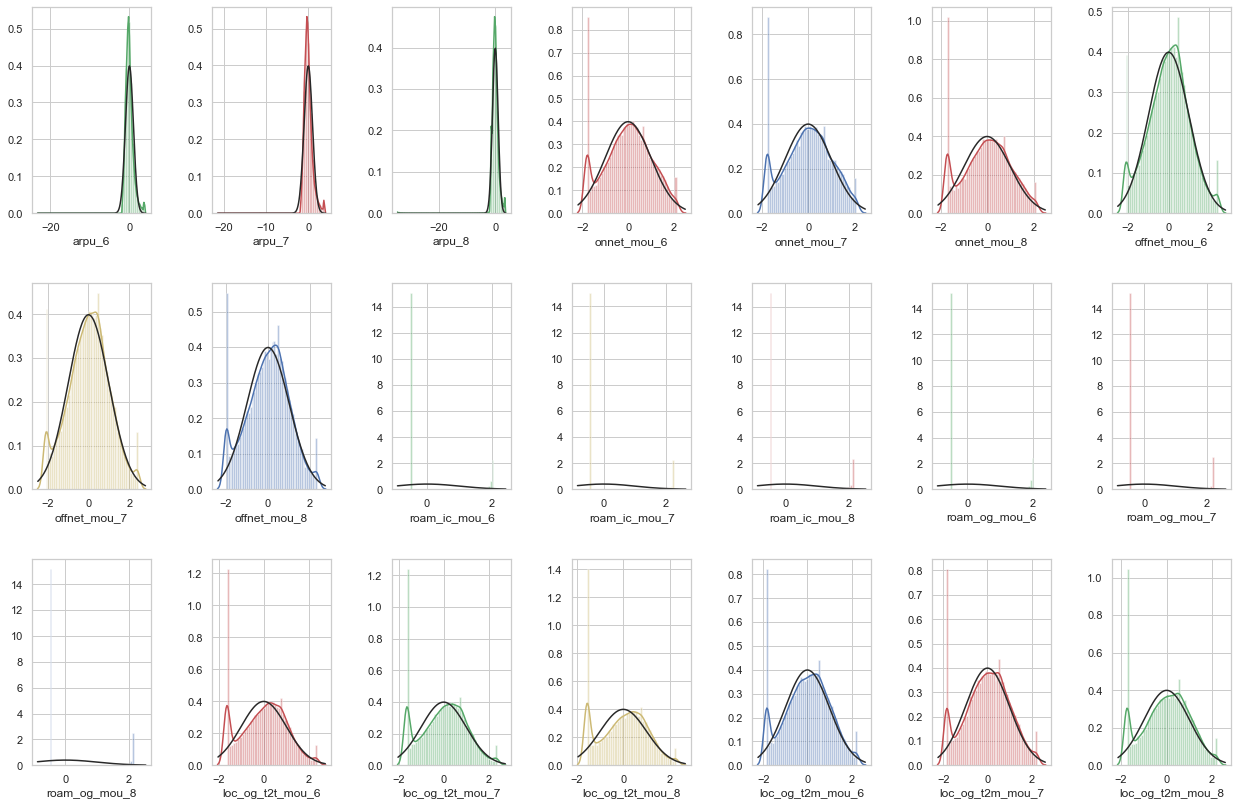

In [81]:
# Plot few distribution plots for verifying the skewness check after applying the power transformer.
plt.figure(figsize = (18,12))
colr = {1:'g', 2:'r', 3:'g', 4:'r', 5:'b', 6:'r', 7:'g', 8:'y', 9:'b',
        10:'g', 11:'y', 12:'r', 13:'g', 14:'r', 15:'b', 16:'r', 17:'g', 18:'y', 19:'b',
        20:'r', 21:'g', 22:'r', 23:'g', 24:'r', 25:'b', 26:'r', 27:'g', 28:'y', 29:'b',
        30:'r', 31:'g', 32:'r', 33:'g', 34:'r', 35:'b', 36:'r', 37:'g', 38:'y', 39:'b',
        40:'y'
       }
sns.set(style="whitegrid")
index=1
for i in numerical_features[1:22]:
    plt.subplot(3,7,index)
    sns.distplot(telecom_churn[i],fit=norm, color=colr[index])
    plt.tight_layout(pad=3.0)
    index=index+1
plt.show();

### Inferences
Now we have the manageable skewness for all numerical variables for the regression.

## 8. Dummy variable Creation for Categorical features

In [82]:
# Check the data type of the Categorical features
telecom_churn[categorical_features].dtypes

monthly_2g_6        object
monthly_2g_7        object
monthly_2g_8        object
monthly_3g_6        object
monthly_3g_7        object
monthly_3g_8        object
sachet_2g_6         object
sachet_2g_7         object
sachet_2g_8         object
sachet_3g_6         object
sachet_3g_7         object
sachet_3g_8         object
night_pck_user_6    object
night_pck_user_7    object
night_pck_user_8    object
fb_user_6           object
fb_user_7           object
fb_user_8           object
dtype: object

In [83]:
#convert categorical variable into dummy
telecom_churn = pd.concat([telecom_churn,pd.get_dummies(telecom_churn[categorical_features], drop_first=True)], axis=1)

# drop the original columns
telecom_churn.drop(categorical_features, axis=1, inplace=True)

In [84]:
telecom_churn.shape

(30001, 226)

## Taking a backup of dataset for modeling using PCA High performing model.

In [85]:
master_df = telecom_churn.copy()

In [86]:
#Restore from backup.
#telecom_churn = master_df.copy()

# 9. Model  Building

## 9.1 Interpretable Model

We decided to proceed with Logistic regression model for the Interpretable model.

### 9.1.1 Remove the Highly corellated columns

In [87]:
# Threshold for removing correlated variables
threshold = 0.7 ## 

# Absolute value correlation matrix
corr_matrix = telecom_churn[numerical_features[1:]].corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

# Remove the columns
telecom_churn = telecom_churn.drop(columns = to_drop)

['onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7

### 9.1.2 Separate X and y

In [88]:
X = telecom_churn.drop(telecom_churn[target_features], axis=1)
train_info_X = X.pop('mobile_number')
y = telecom_churn[target_features]
X.shape, y.shape

((30001, 107), (30001, 1))

### 9.1.3 Split into Train and Test

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 107), (9001, 107), (21000, 1), (9001, 1))

### 9.1.4 Check the imbalance percentage

In [90]:
#Check the class imbalance in train set
y_train.churn.value_counts(normalize = True)

0    0.918476
1    0.081524
Name: churn, dtype: float64

### 9.1.5 Build Model

#### User Defined Function creatin 

In [91]:
def evaluate_model(actual, pred):
    '''
        Method Name : evaluate_model
        Input(s)    : 2 series
        Output(s)   : 4 float values  
        Description :
        - This method gets 2 series (actual and predicted) as inputs and compute the accuracy, ROC, Precision and Recall scores  
        - Then returns the computed scores. 
     '''
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

In [92]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## Model Building

In [93]:
## model with class_weight='balanced'
logreg = LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE)

In [94]:
## Fitting the model 
logreg.fit(X_train, y_train)
y_pred =logreg.predict(X_test)

LogisticRegression(class_weight='balanced', random_state=42)

In [95]:
# List to store the model scores
model_score_list = []

# Store the interpretable Logistic Regression model score into the score list
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred)
model_score_list.append({'model_name':'IntpModel - LogisticRegression', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 
                         'recall_score':rec_score})

# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

Accuracy Score :  85.2
ROC AUC score :  84.44
Precision score :  33.44
Recall score :  83.54

Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.85      0.91      8272
           1       0.33      0.84      0.48       729

    accuracy                           0.85      9001
   macro avg       0.66      0.84      0.70      9001
weighted avg       0.93      0.85      0.88      9001


TN = 7060, FP = 1212, FN = 120, TP = 609




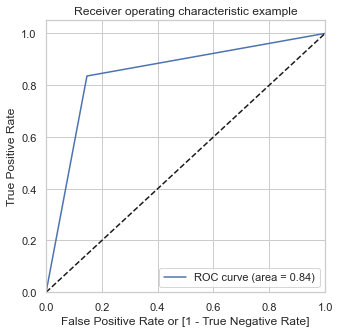

In [96]:
# ROC-AUC curve
draw_roc(y_test, y_pred)

### Inferences 
- The roc seems to be good (0.84)
- We will proceed with recurssive feature elemination and will try to optimize our model 

## 9.2. RFE

In [97]:
## RFE with 25 variables 
rfe = RFE(logreg, 25)
rfe = rfe.fit(X_train, y_train)

In [98]:
## Checking the rfe supported column names 
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('onnet_mou_6', False, 48),
 ('offnet_mou_6', False, 27),
 ('roam_ic_mou_6', False, 77),
 ('roam_ic_mou_7', False, 73),
 ('roam_ic_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 47),
 ('loc_og_t2m_mou_6', True, 1),
 ('loc_og_t2f_mou_6', False, 82),
 ('loc_og_t2f_mou_7', False, 18),
 ('loc_og_t2f_mou_8', False, 31),
 ('loc_og_t2c_mou_6', False, 60),
 ('loc_og_t2c_mou_7', False, 69),
 ('loc_og_t2c_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 17),
 ('std_og_t2m_mou_6', False, 74),
 ('std_og_t2f_mou_6', False, 72),
 ('std_og_t2f_mou_7', False, 71),
 ('std_og_t2f_mou_8', False, 67),
 ('isd_og_mou_6', False, 19),
 ('isd_og_mou_7', False, 53),
 ('isd_og_mou_8', False, 3),
 ('spl_og_mou_6', False, 70),
 ('spl_og_mou_7', False, 61),
 ('spl_og_mou_8', False, 32),
 ('og_others_6', False, 66),
 ('og_others_7', False, 42),
 ('og_others_8', False, 80),
 ('loc_ic_t2f_mou_6', False, 11),
 ('std_ic_t2t_mou_6', False, 54),
 ('std_ic_

In [99]:
# Creating a function for getting VIF.
from statsmodels.stats.outliers_influence import variance_inflation_factor
def f_vif(v_df):
    vif = pd.DataFrame()
    vif['Features'] = v_df.columns
    vif['VIF'] = [variance_inflation_factor(v_df.values, i) for i in range(v_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return(vif)

In [100]:
## Taking the rfe supported columns 
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_rfe= X_test[col]

In [101]:
## Checking the vif 
f_vif(X_train_rfe)

,Features,VIF
24,fb_user_8_1.0,7.06
23,fb_user_7_1.0,4.88
19,sachet_2g_8_Others,4.22
7,count_rech_2g_8,3.59
13,monthly_2g_8_1,2.66
2,arpu_8,2.49
1,arpu_7,2.18
18,sachet_2g_8_1,1.87
0,arpu_6,1.77
15,monthly_3g_8_1,1.70


In [102]:
# Dropping the column with high vif and rechecking the vif after dropping the same 
col = col.drop(['fb_user_8_1.0'], 1)
X_train_rfe = X_train[col]
X_test_rfe= X_test[col]
f_vif(X_train_rfe)

,Features,VIF
19,sachet_2g_8_Others,3.79
7,count_rech_2g_8,3.58
23,fb_user_7_1.0,3.34
2,arpu_8,2.43
13,monthly_2g_8_1,2.29
1,arpu_7,2.15
0,arpu_6,1.77
18,sachet_2g_8_1,1.69
10,monthly_2g_6_1,1.61
21,sachet_3g_7_Others,1.41


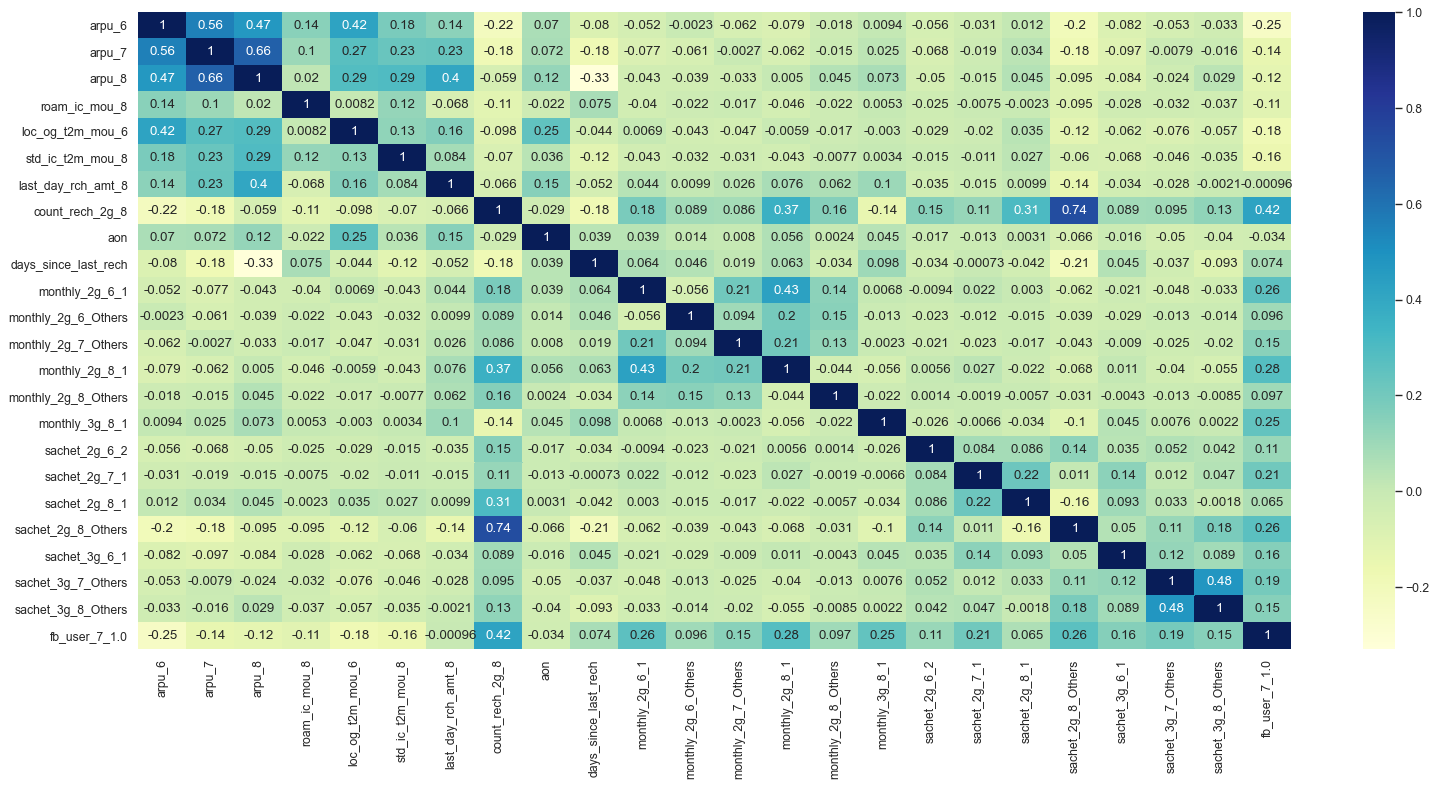

In [103]:
## Plotting the Heatmap to check the coorelation 
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k', frameon='True')

cor = X_train_rfe[col].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")

plt.tight_layout()
plt.show();

### Inferences 
- The Correlation are within the range (- 0.70 to 0.70) except  sachet_2g_8_Others
- we will be dropping that column. 

In [104]:
# Dropping the column with high vif and rechecking the vif after dropping the same 
col = col.drop(['sachet_2g_8_Others'], 1)
X_train_rfe = X_train[col]
X_test_rfe= X_test[col]
f_vif(X_train_rfe)

,Features,VIF
2,arpu_8,2.43
22,fb_user_7_1.0,2.34
1,arpu_7,2.15
13,monthly_2g_8_1,1.83
0,arpu_6,1.76
10,monthly_2g_6_1,1.61
7,count_rech_2g_8,1.54
20,sachet_3g_7_Others,1.41
21,sachet_3g_8_Others,1.39
15,monthly_3g_8_1,1.34


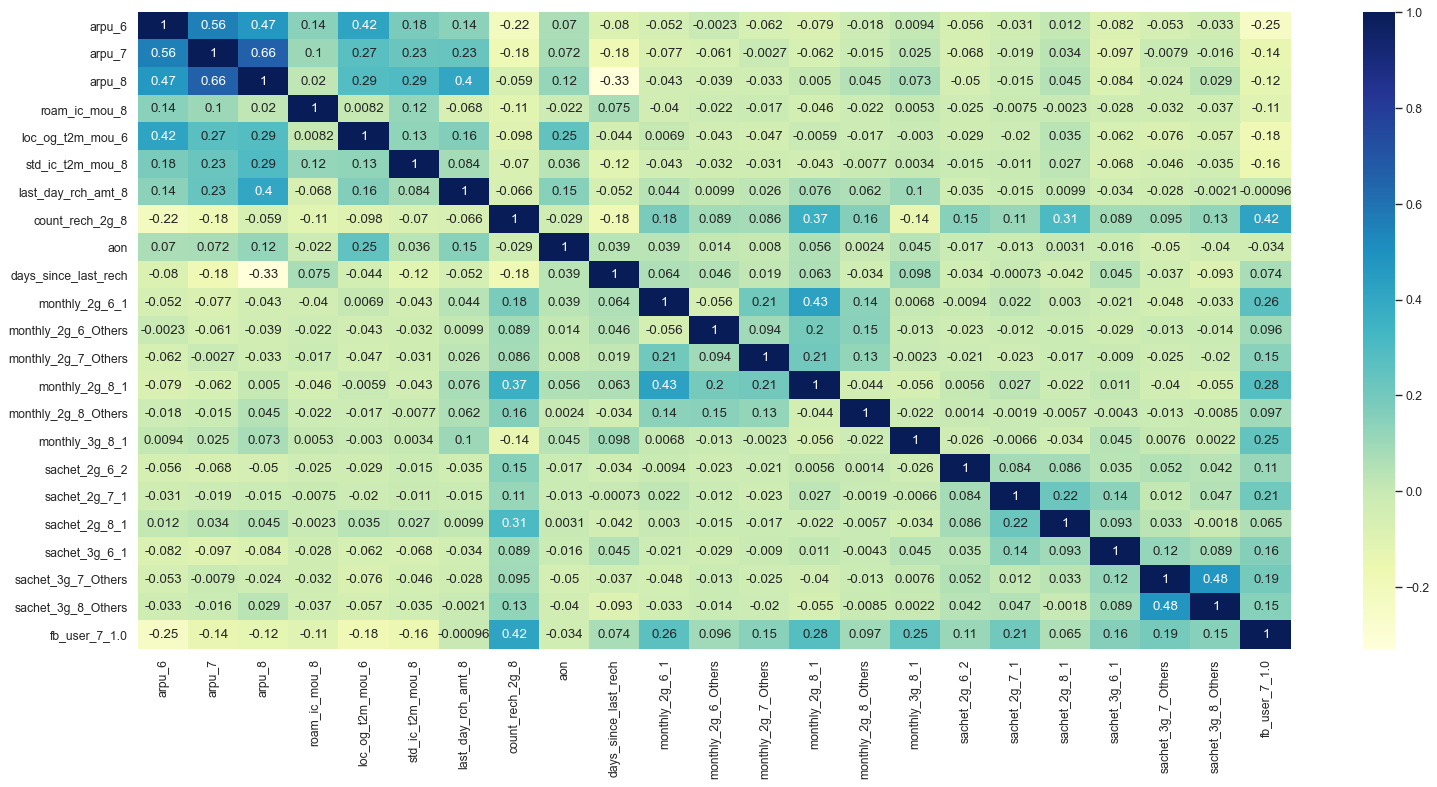

In [105]:
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k', frameon='True')

cor = X_train_rfe[col].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")

plt.tight_layout()
plt.show();

### Inferences 
- All the coorelation are under the range  -0.7 to 0.7 now

## 9.3. Grid search cv to find the best weight and fit

We will proceed with Grid search Weighted logistic regression in order to deal with such scenarios .
References - https://machinelearningmastery.com/cost-sensitive-logistic-regression/ 
 - > **Grid Search Weighted Logistic Regression**

In [106]:
%%time
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid.fit(X_train_rfe, y_train)

Wall time: 9.34 s


In [107]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.913497 using {'class_weight': {0: 1, 1: 10}}
0.909891 (0.012265) with: {'class_weight': {0: 100, 1: 1}}
0.910329 (0.012237) with: {'class_weight': {0: 10, 1: 1}}
0.911956 (0.012020) with: {'class_weight': {0: 1, 1: 1}}
0.913497 (0.011413) with: {'class_weight': {0: 1, 1: 10}}
0.911543 (0.011358) with: {'class_weight': {0: 1, 1: 100}}


In [108]:
# Creating the hyperparameter grid
params = grid_result.best_params_

# Initialize the Logistic regression
modellog = LogisticRegression(solver='lbfgs', **params, random_state=RANDOM_STATE)
# fit the training data
modellog.fit(X_train_rfe, y_train)
# predict the testing data
y_pred_rfe = modellog.predict(X_test_rfe)
# get the predict probablities of testing dataset
y_pred_proba_rfe = modellog.predict_proba(X_test_rfe)

LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)

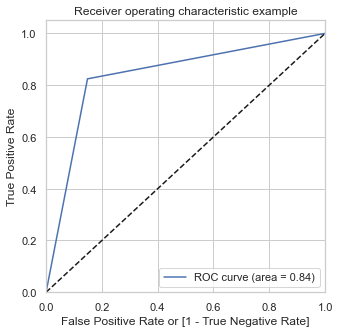

In [109]:
draw_roc(y_test, y_pred_rfe)

### Inferences 
- The Roc with default cutoff 0.5 is 0.84

### 9.4. Optimal probability cutoff

In [110]:
# Frame the dataset with the predicted probabilities
y_pred_final_rfe = pd.DataFrame({'actual':y_test['churn'],
                             'pred_nonchurn_prob':y_pred_proba_rfe[:,0],
                             'pred_churn_prob':y_pred_proba_rfe[:,1],
                             'predicted':y_pred_rfe})
y_pred_final_rfe.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
35865,0,0.160536,0.839464,1
41952,0,0.925460,0.074540,0
98938,0,0.869363,0.130637,0
29459,0,0.842290,0.157710,0
70682,0,0.716424,0.283576,0


     prob  accuracy     sensi     speci
0.0   0.0  0.080991  0.000000  1.000000
0.1   0.1  0.501389  0.459260  0.979424
0.2   0.2  0.670925  0.646881  0.943759
0.3   0.3  0.760138  0.746132  0.919067
0.4   0.4  0.811132  0.805488  0.875171
0.5   0.5  0.849350  0.851547  0.824417
0.6   0.6  0.879013  0.890716  0.746228
0.7   0.7  0.899789  0.920455  0.665295
0.8   0.8  0.916454  0.946929  0.570645
0.9   0.9  0.927675  0.974009  0.401920


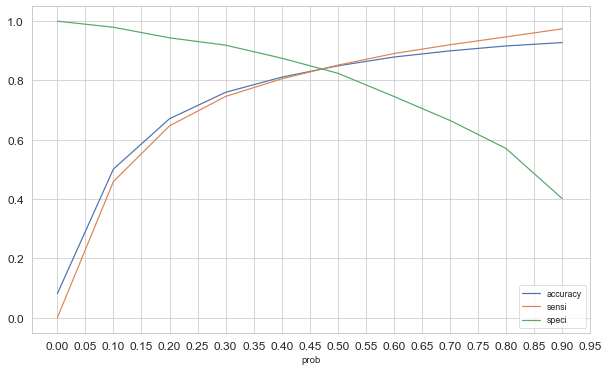

In [111]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final_rfe[i]= y_pred_final_rfe['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
y_pred_final_rfe.head()

# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred_final_rfe['actual'], y_pred_final_rfe[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

# Slightly alter the figure size to make it more horizontal.
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show();

### Inferences 
- We will take the cutoff point as 0.47 and will try to evaqluate the metrices 

In [112]:
## Taking the cutoff at 0.47
y_pred_final_rfe['final_predicted'] = y_pred_final_rfe['pred_churn_prob'].map( lambda x: 1 if x > 0.47 else 0)


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.84      0.90      8272
           1       0.31      0.84      0.45       729

    accuracy                           0.84      9001
   macro avg       0.65      0.84      0.68      9001
weighted avg       0.93      0.84      0.87      9001


TN = 6913, FP = 1359, FN = 116, TP = 613


Accuracy Score :  83.61
ROC AUC score :  83.83
Precision score :  31.09
Recall score :  84.09


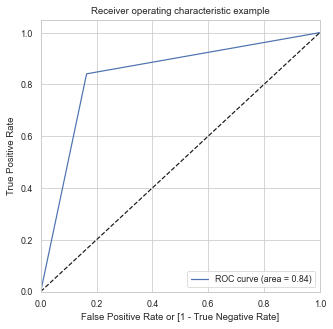

In [113]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_final_rfe['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_rfe['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_final_rfe['final_predicted'])

# add the model scores to score list
model_score_list.append({'model_name':'IntpModel Model - LogisticRegression(Optimized)', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

# ROC-AUC curve on test set
draw_roc(y_test, y_pred_final_rfe['final_predicted'])

### Inferences
- The Area = 0.84 

## 9.5. Feature Importance for interpretable model

In [114]:
print(modellog.coef_, modellog.intercept_)

[[ 0.29480904  0.34103979 -0.49915216  0.81846549 -0.29911327 -0.32444001
  -0.70296772 -0.41354649 -0.25547528  0.88448613 -0.38392134 -0.69736846
  -0.64868846 -0.85274462 -1.09206983 -1.30131295 -0.27758829 -0.35065679
   0.26202237 -0.26665078  0.45603951 -0.59040738  0.11871785]] [-1.26580739]


monthly_3g_8_1          1.301313
monthly_2g_8_Others     1.092070
days_since_last_rech    0.884486
monthly_2g_8_1          0.852745
roam_ic_mou_8           0.818465
last_day_rch_amt_8      0.702968
monthly_2g_6_Others     0.697368
monthly_2g_7_Others     0.648688
sachet_3g_8_Others      0.590407
arpu_8                  0.499152
sachet_3g_7_Others      0.456040
count_rech_2g_8         0.413546
monthly_2g_6_1          0.383921
sachet_2g_7_1           0.350657
arpu_7                  0.341040
std_ic_t2m_mou_8        0.324440
loc_og_t2m_mou_6        0.299113
arpu_6                  0.294809
sachet_2g_6_2           0.277588
sachet_3g_6_1           0.266651
sachet_2g_8_1           0.262022
aon                     0.255475
fb_user_7_1.0           0.118718
Name: Feature Importance, dtype: float64

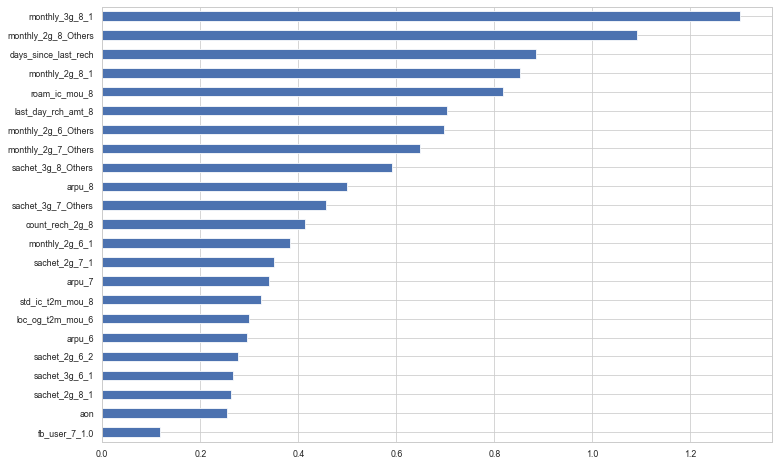

In [115]:
# Plot features by importance (feature coefficient in the model)
# Absolute value of Feature Importance
coeff = pd.DataFrame({'Feature Importance':modellog.coef_.tolist()[0]}, index=X_test_rfe.columns)
coeff[coeff['Feature Importance'] != 0]['Feature Importance'].abs().sort_values().plot(kind='barh',figsize=(12,8))
coeff['Feature Importance'].abs().sort_values(ascending = False)

In [116]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
1,IntpModel Model - LogisticRegression(Optimized),83.61,83.83,31.09,84.09
0,IntpModel - LogisticRegression,85.20,84.44,33.44,83.54


### Inferences 
- After looking at the above table we can see that both Interpretable models are giving the promising results, hence we can use any of the model for feature importance and there analysis.
- The features are plotted in the graph with descending importance.

## 10. Model Building Using PCA 

### 10.1 Restore Dataframe from backup 

In [117]:
#Restore from backup.
telecom_churn = master_df.copy()
#Define X & y
X = telecom_churn.drop(telecom_churn[target_features], axis=1)
train_info_X = X.pop('mobile_number')
y = telecom_churn[target_features]
X.shape, y.shape

((30001, 224), (30001, 1))

### 10.2 Test Train split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21000, 224) (21000, 1)
(9001, 224) (9001, 1)


### 10.3 Use SMOTE to handle the class imbalance 

In [119]:
# Handle class inbalance with SOMTE.
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_sample(X_train, y_train)

# Value counts.
y_train.churn.value_counts(normalize = True)

1    0.5
0    0.5
Name: churn, dtype: float64

### 10.4 PCA and ScreePlotting

In [120]:
#initialize the pca with randomized
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
# fit the training dataset
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

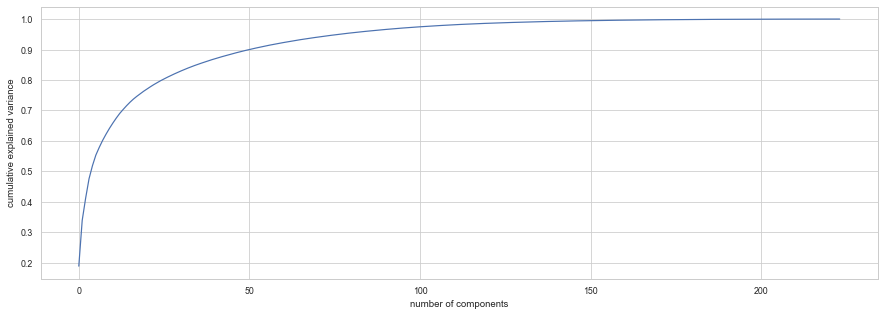

In [121]:
#Screeplot for the PCA components
%matplotlib inline
fig = plt.figure(figsize = (15,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show();

In [122]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([18.94, 33.96, 41.21, 47.61, 51.89, 55.38, 57.92, 60.23, 62.27,
       64.17, 65.91, 67.54, 69.05, 70.34, 71.57, 72.71, 73.74, 74.65,
       75.49, 76.32, 77.08, 77.81, 78.52, 79.17, 79.8 , 80.38, 80.94,
       81.48, 82.  , 82.5 , 82.99, 83.46, 83.91, 84.35, 84.76, 85.16,
       85.54, 85.92, 86.29, 86.65, 86.99, 87.33, 87.65, 87.96, 88.27,
       88.57, 88.87, 89.16, 89.44, 89.71, 89.97, 90.23, 90.48, 90.72,
       90.96, 91.2 , 91.42, 91.64, 91.85, 92.06, 92.26, 92.46, 92.65,
       92.84, 93.03, 93.21, 93.38, 93.55, 93.71, 93.87, 94.03, 94.18,
       94.33, 94.48, 94.63, 94.77, 94.91, 95.05, 95.19, 95.32, 95.45,
       95.57, 95.69, 95.81, 95.93, 96.04, 96.15, 96.26, 96.37, 96.47,
       96.57, 96.67, 96.77, 96.86, 96.95, 97.04, 97.13, 97.21, 97.29,
       97.37, 97.45, 97.52, 97.59, 97.66, 97.73, 97.8 , 97.86, 97.92,
       97.98, 98.04, 98.1 , 98.16, 98.22, 98.27, 98.32, 98.37, 98.42,
       98.47, 98.52, 98.56, 98.6 , 98.64, 98.68, 98.72, 98.76, 98.8 ,
       98.84, 98.87,

#### From the screeplot we can observe that For variance of ~90% we get ~50 components.Hence choosing the 50 components for the model.

In [123]:
# Initialize pca with 50 components
pca = PCA(n_components=50, random_state=RANDOM_STATE)
# fit and transform the training dataset
X_train_pca = pca.fit_transform(X_train)
# transform the testing dataset
X_test_pca = pca.transform(X_test)
# fit and transform the whole dataset
X_pca = pca.fit_transform(X)


In [124]:
# Create a dataframe for futures and their PCA scores.
pca_train_scores = pd.DataFrame(pd.Series(pca.components_[0], index = X_train.columns))
pca_train_scores.reset_index()
pca_train_scores.columns = ['score']
print(pca_train_scores)
pca_df=pd.DataFrame({'Feature':list(X.columns),'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2]})
pca_df.head()

,index,0
0,arpu_6,0.084778
1,arpu_7,0.088316
2,arpu_8,0.080500
3,onnet_mou_6,0.113583
4,onnet_mou_7,0.118233
5,onnet_mou_8,0.113927
6,offnet_mou_6,0.118230
7,offnet_mou_7,0.123322
8,offnet_mou_8,0.115889
9,roam_ic_mou_6,0.023930


                              score
arpu_6                     0.084778
arpu_7                     0.088316
arpu_8                     0.080500
onnet_mou_6                0.113583
onnet_mou_7                0.118233
onnet_mou_8                0.113927
offnet_mou_6               0.118230
offnet_mou_7               0.123322
offnet_mou_8               0.115889
roam_ic_mou_6              0.023930
roam_ic_mou_7              0.020305
roam_ic_mou_8              0.024844
roam_og_mou_6              0.025059
roam_og_mou_7              0.021032
roam_og_mou_8              0.026330
loc_og_t2t_mou_6           0.083637
loc_og_t2t_mou_7           0.090921
loc_og_t2t_mou_8           0.084542
loc_og_t2m_mou_6           0.084574
loc_og_t2m_mou_7           0.092713
loc_og_t2m_mou_8           0.084713
loc_og_t2f_mou_6           0.036324
loc_og_t2f_mou_7           0.038489
loc_og_t2f_mou_8           0.038618
loc_og_t2c_mou_6           0.006120
loc_og_t2c_mou_7           0.007486
loc_og_t2c_mou_8           0

,Feature,PC1,PC2,PC3
0,arpu_6,0.084778,0.042496,-0.061802
1,arpu_7,0.088316,0.046005,-0.081169
2,arpu_8,0.080500,0.067734,-0.075991
3,onnet_mou_6,0.113583,-0.002697,-0.038837
4,onnet_mou_7,0.118233,-0.001248,-0.048326


## 10.5 Model Building (without hyper parameter tuning)- Baseline model with PCA

### 10.5.1 Logistic Regression

In [125]:
%%time
# Initialize the Logistic regression
model = LogisticRegression(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, y_train)
# predict the testing pca data
y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred)
# add the model scores to score list 
model_score_list.append({'model_name':'HP Model - LogisticRegression', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  86.35
ROC AUC score :  84.69
Precision score :  34.36
Recall score :  82.74
Wall time: 209 ms


### 10.5.2. KNeighbors classifiers

In [126]:
%%time
# initialize the KNeighbors classifiers
model = KNeighborsClassifier()
# fit the pca training data
model.fit(X_train_pca, y_train)
# predict the pca testing data
y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'HP Model - KNeighborsClassifier', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  82.27
ROC AUC score :  80.2
Precision score :  27.46
Recall score :  77.75
Wall time: 34.4 s


### 10.5.3. Ridge Classifiers

In [127]:
# initialize the Ridge Classifier
model = RidgeClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, y_train)
# predict the pca testing data
y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'HP Model - RidgeClassifier', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

RidgeClassifier(random_state=42)

Accuracy Score :  86.5
ROC AUC score :  84.78
Precision score :  34.65
Recall score :  82.74


### 10.5.4. XGBClassifier  

In [128]:
# Initialize the XGBoost
model = XGBClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, y_train)
# predict the pca testing data
y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'HP Model - XGBClassifier', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy Score :  91.7
ROC AUC score :  78.72
Precision score :  47.54
Recall score :  63.34


In [129]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
1,IntpModel Model - LogisticRegression(Optimized),83.61,83.83,31.09,84.09
0,IntpModel - LogisticRegression,85.20,84.44,33.44,83.54
4,HP Model - RidgeClassifier,86.50,84.78,34.65,82.74
2,HP Model - LogisticRegression,86.35,84.69,34.36,82.74
3,HP Model - KNeighborsClassifier,82.27,80.20,27.46,77.75
5,HP Model - XGBClassifier,91.70,78.72,47.54,63.34


## Inferences 
- The 3 Best model (after PCA) are
    - HP Model - LogisticRegression   as recall= 82.74 and ROC= 84.69
    - HP Model - RidgeClassifier      as recall= 82.74 and ROC= 84.78
    - HP Model - KNeighborsClassifier as recall= 77.54 and ROC= 80.20

## 11. Hyper Parameter Tuning After PCA and Base modeling 

### 11.1 Hyper Parameter Tuning - Logistic regression 

In [130]:
# cross validation
folds = 5

# Instantiating the GridSearchCV object 
grid_search = GridSearchCV(cv=folds, estimator=LogisticRegression(),
                         param_grid={'C': np.logspace(-5, 8, 20)},
                         scoring='recall', 
                         return_train_score=True, 
                         n_jobs = -1, 
                         verbose = 3)

#fit
grid_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 4.83293024e-05, 2.33572147e-04, 1.12883789e-03,
       5.45559478e-03, 2.63665090e-02, 1.27427499e-01, 6.15848211e-01,
       2.97635144e+00, 1.43844989e+01, 6.95192796e+01, 3.35981829e+02,
       1.62377674e+03, 7.84759970e+03, 3.79269019e+04, 1.83298071e+05,
       8.85866790e+05, 4.28133240e+06, 2.06913808e+07, 1.00000000e+08])},
             return_train_score=True, scoring='recall', verbose=3)

In [131]:
# print the grid results
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best score:')
print(grid_search.best_score_)
print('\n Best parameters:')
print(grid_search.best_params_)


 Best estimator:
LogisticRegression(C=14.38449888287663)

 Best score:
0.8612668743509865

 Best parameters:
{'C': 14.38449888287663}


## 11.1.1 Fitting Logistic regression model with best estimator values 

In [132]:
# initialize the model with the best estimor
model1 = grid_search.best_estimator_

# fit the pca training dataset
model1.fit(X_train_pca, y_train)

# Predict the model with the pca testing dataset
y_pred_1 = model1.predict(X_test_pca)

# get the predict probablities of pca testing dataset
y_pred_proba_1 = model1.predict_proba(X_test_pca)

LogisticRegression(C=14.38449888287663)

### Model Evaluation 

In [133]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_1))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_1).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_1)


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.87      0.92      8300
           1       0.34      0.83      0.49       701

    accuracy                           0.86      9001
   macro avg       0.66      0.85      0.70      9001
weighted avg       0.93      0.86      0.89      9001


TN = 7192, FP = 1108, FN = 121, TP = 580


Accuracy Score :  86.35
ROC AUC score :  84.69
Precision score :  34.36
Recall score :  82.74


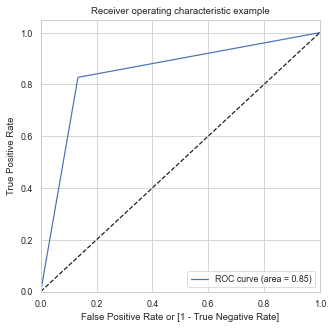

In [134]:
# ROC-AUC curve
draw_roc(y_test, y_pred_1)

### Inferences 
- The Roc with default cutoff 0.5 is 0.85

 ### Optimal probability cutoff

In [135]:
# Frame the dataset with the predicted probabilities
y_pred_final_1 = pd.DataFrame({'actual':y_test['churn'],
                             'pred_nonchurn_prob':y_pred_proba_1[:,0],
                             'pred_churn_prob':y_pred_proba_1[:,1],
                             'predicted':y_pred_1})
y_pred_final_1.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
7526,0,0.979818,0.020182,0
74907,1,0.061832,0.938168,1
99617,0,0.012763,0.987237,1
83565,0,0.935651,0.064349,0
8695,0,0.625755,0.374245,0


     prob  accuracy     sensi     speci
0.0   0.0  0.077880  0.000000  1.000000
0.1   0.1  0.567159  0.533253  0.968616
0.2   0.2  0.715587  0.698072  0.922967
0.3   0.3  0.792023  0.783253  0.895863
0.4   0.4  0.836352  0.834096  0.863053
0.5   0.5  0.863460  0.866506  0.827389
0.6   0.6  0.887679  0.896386  0.784593
0.7   0.7  0.905122  0.919157  0.738944
0.8   0.8  0.924675  0.945181  0.681883
0.9   0.9  0.936785  0.970000  0.543509


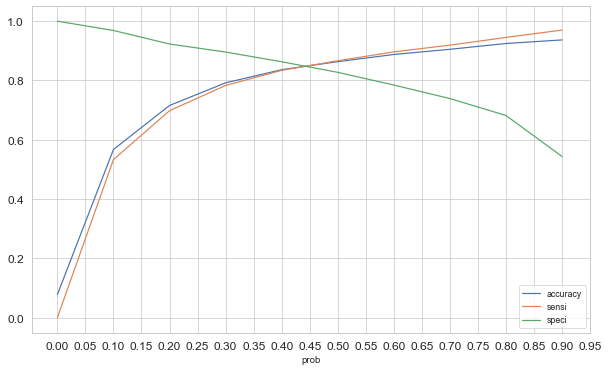

In [136]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final_1[i]= y_pred_final_1['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
y_pred_final_1.head()

# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred_final_1['actual'], y_pred_final_1[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

# Slightly alter the figure size to make it more horizontal.
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show();

### Inferences 
- The Cutoff of 0.44 seems more reasonable from the above figure


In [137]:
y_pred_final_1['final_predicted'] = y_pred_final_1['pred_churn_prob'].map( lambda x: 1 if x > 0.44 else 0)

## 11.1.2 Final Model for Logistic Regression with Hyper param tuning 


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.85      0.91      8300
           1       0.32      0.85      0.47       701

    accuracy                           0.85      9001
   macro avg       0.65      0.85      0.69      9001
weighted avg       0.93      0.85      0.88      9001


TN = 7035, FP = 1265, FN = 104, TP = 597


Accuracy Score :  84.79
ROC AUC score :  84.96
Precision score :  32.06
Recall score :  85.16


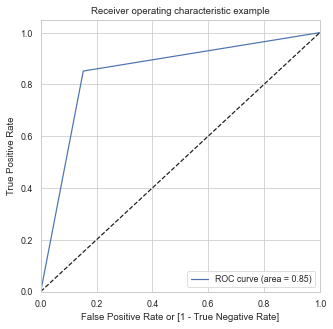

In [138]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_final_1['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_1['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_final_1['final_predicted'])

# add the model scores to score list
model_score_list.append({'model_name':'HP Model - LogisticRegression(Optimized)', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

# ROC-AUC curve on test set
draw_roc(y_test, y_pred_final_1['final_predicted'])

## Inference 
- There isnt much Change in the ROC with cutoff of 0.44 and 0.5 . We have added it to our evaluation Dataframe which we will be using in future to evaluate

## 11.2 Hyper parameter Tuning - Kneighbour Classifiers 

In [139]:
%%time
# Hyperparameter Tuning for KNeighborsClassifier
n_splits = 5
# Number of neighbors
n_neighbors =  range(1, 21, 2)
# Power parameter for the distance metric
p = [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]
metric = ['euclidean', 'manhattan', 'minkowski']
# Create the parameter grid
params = {'n_neighbors': n_neighbors,'p': p, 'metric': metric}

# initialize the KNN model
model = KNeighborsClassifier(weights='uniform', n_jobs=-1)

# initialize the StratifiedKFold 
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# initialize the RandomSearchCV
grid_result = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter = 1, scoring='recall', 
                          n_jobs=-1, cv=skf.split(X_train_pca,y_train), verbose=3, random_state=RANDOM_STATE )

# fit the whole pca dataset
grid_result.fit(X_train_pca, y_train)

# summarize results
# print the grid results
print('\n Best estimator:', grid_result.best_estimator_)
print('\n Best score:', grid_result.best_score_)
print('\n Best parameters:', grid_result.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.7s remaining:   53.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.9s finished



 Best estimator: KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=7)

 Best score: 0.9991173416407062

 Best parameters: {'p': 2, 'n_neighbors': 7, 'metric': 'manhattan'}
Wall time: 36.7 s


## 11.2.1 Kneighbour Classifiers Fitting with best estimators 

In [140]:
%%time
# initialize the model with the best estimor
model2 = grid_result.best_estimator_

# fit the pca training dataset
model2.fit(X_train_pca, y_train)

# Predict the model with the pca testing dataset
y_pred_2 = model2.predict(X_test_pca)

# get the predict probablities of pca testing dataset
y_pred_proba_2 = model2.predict_proba(X_test_pca)

Wall time: 24.2 s


### Model Evaluation 


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.80      0.88      8300
           1       0.26      0.82      0.40       701

    accuracy                           0.81      9001
   macro avg       0.62      0.81      0.64      9001
weighted avg       0.93      0.81      0.85      9001


TN = 6672, FP = 1628, FN = 124, TP = 577


Accuracy Score :  80.54
ROC AUC score :  81.35
Precision score :  26.17
Recall score :  82.31


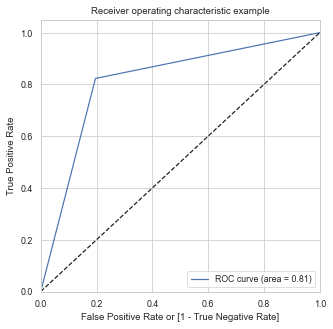

In [141]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_2))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_2).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_2)
# ROC-AUC curve
draw_roc(y_test, y_pred_2)

### Optimal probability cutoff 

In [142]:
# Frame the dataset with the predicted probabilities
y_pred_final_2 = pd.DataFrame({'actual':y_test['churn'],
                             'pred_nonchurn_prob':y_pred_proba_2[:,0],
                             'pred_churn_prob':y_pred_proba_2[:,1],
                             'predicted':y_pred_2})
y_pred_final_2.head()
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final_2[i]= y_pred_final_2['pred_churn_prob'].map( lambda x: 1 if x > i else 0)


,actual,pred_nonchurn_prob,pred_churn_prob,predicted
7526,0,1.000000,0.000000,0
74907,1,0.428571,0.571429,1
99617,0,0.142857,0.857143,1
83565,0,1.000000,0.000000,0
8695,0,0.428571,0.571429,1


     prob  accuracy     sensi     speci
0.0   0.0  0.613710  0.588675  0.910128
0.1   0.1  0.613710  0.588675  0.910128
0.2   0.2  0.696478  0.680723  0.883024
0.3   0.3  0.758471  0.750602  0.851641
0.4   0.4  0.758471  0.750602  0.851641
0.5   0.5  0.805355  0.803855  0.823110
0.6   0.6  0.849461  0.855542  0.777461
0.7   0.7  0.849461  0.855542  0.777461
0.8   0.8  0.885457  0.901084  0.700428
0.9   0.9  0.911899  0.944096  0.530670


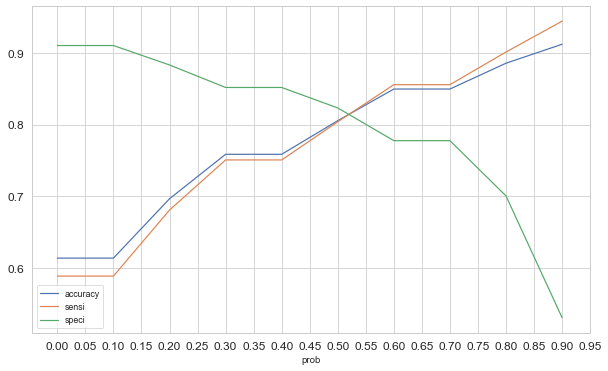

In [143]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred_final_2['actual'], y_pred_final_2[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

# Slightly alter the figure size to make it more horizontal.
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show();

### Inferences 
- As per the above figure the Cuttoff seems to be good at 0.53

In [144]:
y_pred_final_2['final_predicted'] = y_pred_final_2['pred_churn_prob'].map( lambda x: 1 if x > 0.53 else 0)

## 11.2.2 Final Model for Kneighbour Classifiers with Hyper param tuning 


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.80      0.88      8300
           1       0.26      0.82      0.40       701

    accuracy                           0.81      9001
   macro avg       0.62      0.81      0.64      9001
weighted avg       0.93      0.81      0.85      9001


TN = 6672, FP = 1628, FN = 124, TP = 577


Accuracy Score :  80.54
ROC AUC score :  81.35
Precision score :  26.17
Recall score :  82.31


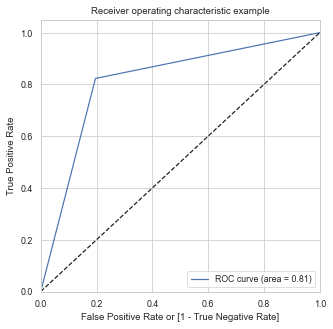

In [145]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_final_2['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_2['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_final_2['final_predicted'])

# add the model scores to score list
model_score_list.append({'model_name':'HP Model - KNeighborsClassifier(Optimized)', 'acc_score':acc_score, 
                         'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})
# ROC-AUC curve
draw_roc(y_test, y_pred_final_2['final_predicted'])


## Inferences 
- The Area under curve seems to have reduced in this case to 0.81.

## 11.3 Hyper parameter Tuning - RidgeClassifier

In [146]:
# list of alphas to tune
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

model = RidgeClassifier()

# cross validation
folds = 5
grid_result = GridSearchCV(estimator = model, 
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
grid_result.fit(X_train_pca, y_train)
print('\n Best estimator:', grid_result.best_estimator_)
print('\n Best score:', grid_result.best_score_)
print('\n Best parameters:', grid_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.3s finished


GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             return_train_score=True, scoring='recall', verbose=1)


 Best estimator: RidgeClassifier(alpha=0.1)

 Best score: 0.8559190031152648

 Best parameters: {'alpha': 0.1}


## 11.3.1 RidgeClassifier Fitting with best estimators 

In [147]:
# initialize the model with the best estimor
model3 = grid_result.best_estimator_

# fit the pca training dataset
model3.fit(X_train_pca, y_train)

# Predict the model with the pca testing dataset
y_pred_3 = model3.predict(X_test_pca)

RidgeClassifier(alpha=0.1)

### Model Evaluation for RidgeClassifier


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.87      0.92      8300
           1       0.35      0.83      0.49       701

    accuracy                           0.87      9001
   macro avg       0.66      0.85      0.71      9001
weighted avg       0.93      0.87      0.89      9001


TN = 7206, FP = 1094, FN = 121, TP = 580


Accuracy Score :  86.5
ROC AUC score :  84.78
Precision score :  34.65
Recall score :  82.74


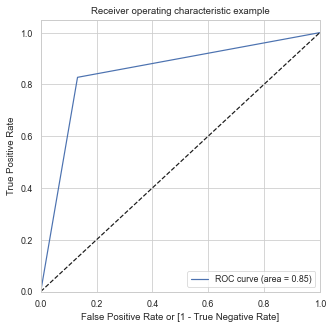

In [148]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_3))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_3).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_3)

draw_roc(y_test, y_pred_3)

### Optimal probability cutoff 

     prob  accuracy     sensi     speci
0.0   0.0  0.613710  0.588675  0.910128
0.1   0.1  0.613710  0.588675  0.910128
0.2   0.2  0.696478  0.680723  0.883024
0.3   0.3  0.758471  0.750602  0.851641
0.4   0.4  0.758471  0.750602  0.851641
0.5   0.5  0.805355  0.803855  0.823110
0.6   0.6  0.849461  0.855542  0.777461
0.7   0.7  0.849461  0.855542  0.777461
0.8   0.8  0.885457  0.901084  0.700428
0.9   0.9  0.911899  0.944096  0.530670


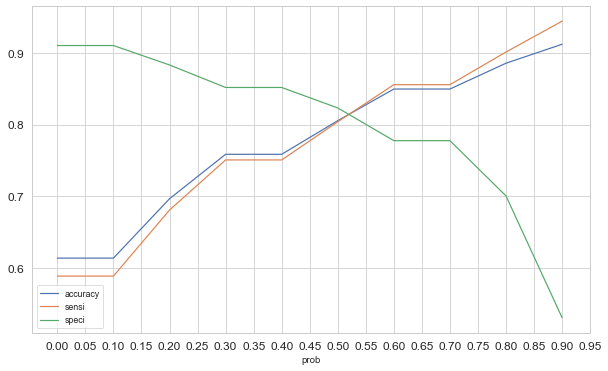

In [149]:
# Frame the dataset with the predicted probabilities
y_pred_final_3 = pd.DataFrame({'actual':y_test['churn'],
                             'pred_nonchurn_prob':y_pred_proba_2[:,0],
                             'pred_churn_prob':y_pred_proba_2[:,1],
                             'predicted':y_pred_2})
y_pred_final_3.head()
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final_3[i]= y_pred_final_3['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
    
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred_final_3['actual'], y_pred_final_3[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

# Slightly alter the figure size to make it more horizontal.
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show();    

In [150]:
y_pred_final_3['final_predicted'] = y_pred_final_3['pred_churn_prob'].map( lambda x: 1 if x > 0.53 else 0)

### 11.3.2 Final Model for RidgeClassifier with Hyper param tuning


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.80      0.88      8300
           1       0.26      0.82      0.40       701

    accuracy                           0.81      9001
   macro avg       0.62      0.81      0.64      9001
weighted avg       0.93      0.81      0.85      9001


TN = 6672, FP = 1628, FN = 124, TP = 577


Accuracy Score :  80.54
ROC AUC score :  81.35
Precision score :  26.17
Recall score :  82.31


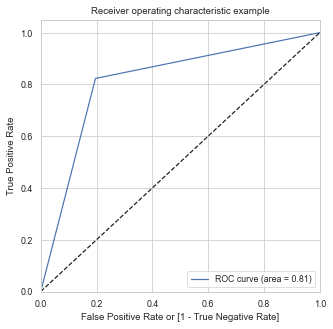

In [151]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(y_test, y_pred_final_3['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_3['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_test, y_pred_final_3['final_predicted'])

# add the model scores to score list
model_score_list.append({'model_name':'HP Model - RidgeClassifier(Optimized)', 'acc_score':acc_score, 
                        'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})
# ROC-AUC curve
draw_roc(y_test, y_pred_final_3['final_predicted'])


## 12. Comprehensive Model evaluation with the Model Scores

In [152]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,
                              columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score','acc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
6,HP Model - LogisticRegression(Optimized),84.79,84.96,32.06,85.16
1,IntpModel Model - LogisticRegression(Optimized),83.61,83.83,31.09,84.09
0,IntpModel - LogisticRegression,85.20,84.44,33.44,83.54
4,HP Model - RidgeClassifier,86.50,84.78,34.65,82.74
2,HP Model - LogisticRegression,86.35,84.69,34.36,82.74
7,HP Model - KNeighborsClassifier(Optimized),80.54,81.35,26.17,82.31
8,HP Model - RidgeClassifier(Optimized),80.54,81.35,26.17,82.31
3,HP Model - KNeighborsClassifier,82.27,80.20,27.46,77.75
5,HP Model - XGBClassifier,91.70,78.72,47.54,63.34


***From the above table we can conclude that among the High performance models(i.e models which were created Using PCA) the below is the best model as per the Recall Score , Roc Score and Accuracy*** 
-  High Performance Model - HP Model - LogisticRegression(Optimized)	

***In case of interpretable model*** 
- IntpModel Model - LogisticRegression(Optimized)
is the best model as per our analysis 

## 13. Best Model Interpretation 

### 13.1 High Performance Model - HP Model - LogisticRegression(Optimized)

Feature
og_others_7         0.501378
loc_og_t2m_mou_8    0.493373
isd_og_mou_7        0.450228
arpu_8              0.437410
onnet_mou_8         0.389425
roam_ic_mou_7       0.322516
roam_og_mou_6       0.312865
arpu_7              0.309538
loc_og_mou_6        0.279807
std_og_mou_7        0.271596
spl_og_mou_6        0.269923
loc_og_t2c_mou_6    0.257898
loc_og_mou_7        0.231680
og_others_6         0.220167
loc_og_mou_8        0.201498
offnet_mou_7        0.188645
std_og_t2m_mou_8    0.143181
isd_og_mou_8        0.137225
roam_ic_mou_8       0.104956
loc_og_t2t_mou_8    0.103086
loc_og_t2f_mou_7    0.101284
loc_og_t2m_mou_7    0.099818
std_og_t2t_mou_6    0.097380
offnet_mou_8        0.087907
std_og_t2m_mou_7    0.074011
std_og_t2m_mou_6    0.070144
std_og_t2f_mou_8    0.068196
roam_og_mou_7       0.059935
roam_og_mou_8       0.054491
std_og_mou_6        0.052408
arpu_6              0.043447
std_og_mou_8        0.042967
roam_ic_mou_6       0.038717
loc_og_t2f_mou_6    0.036825
std_og

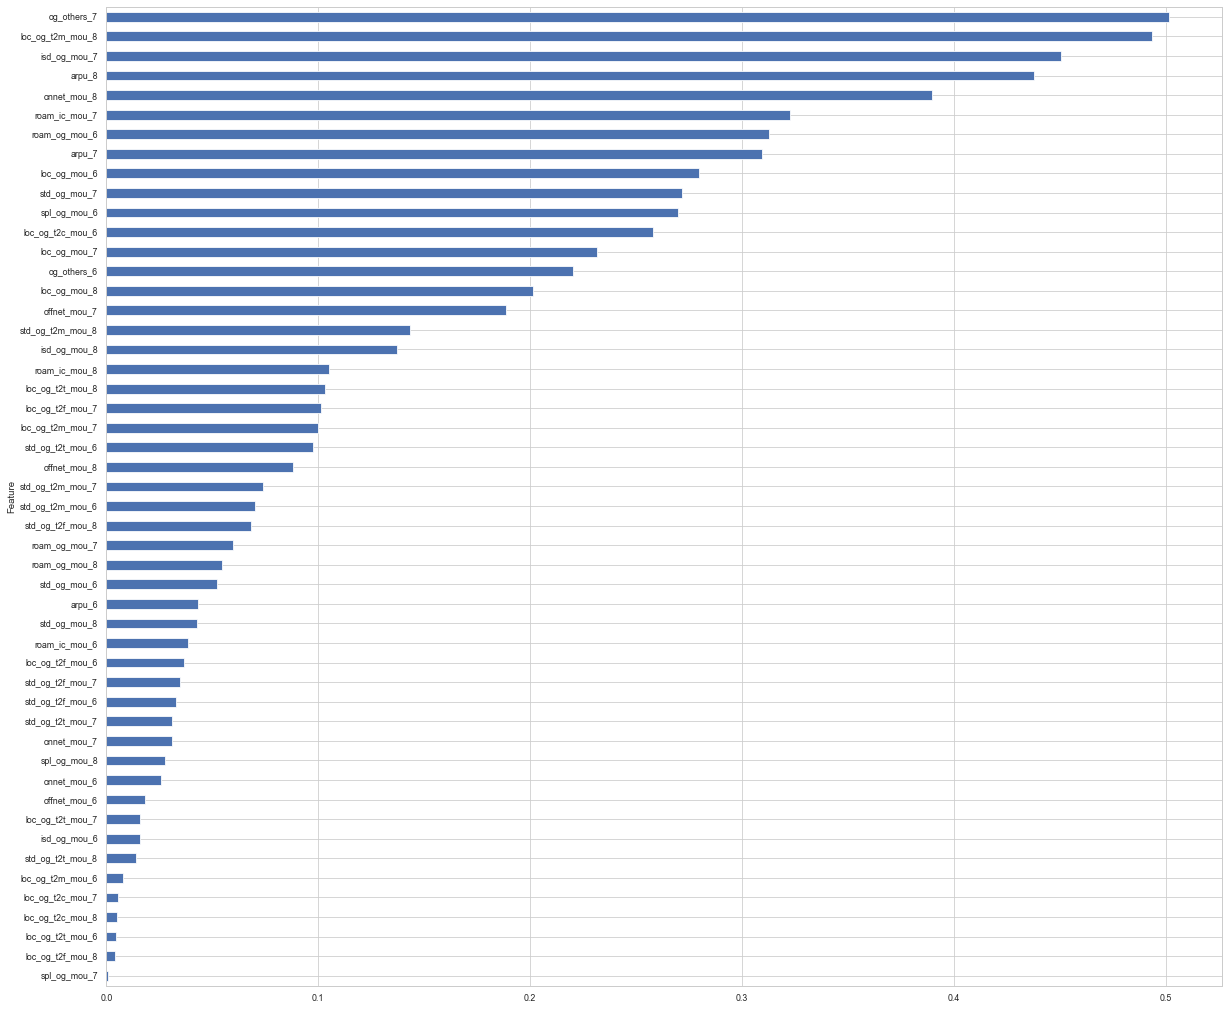

In [153]:
# plot for Absolute value of Feature Importance
coeff = pd.DataFrame({'Feature Importance':model1.coef_.tolist()[0]}, index=pca_df['Feature'][:50])
coeff[coeff['Feature Importance'] != 0]['Feature Importance'].abs().sort_values().plot(kind='barh',figsize=(20,18))
coeff['Feature Importance'].abs().sort_values(ascending = False)

## Top 10 Features 

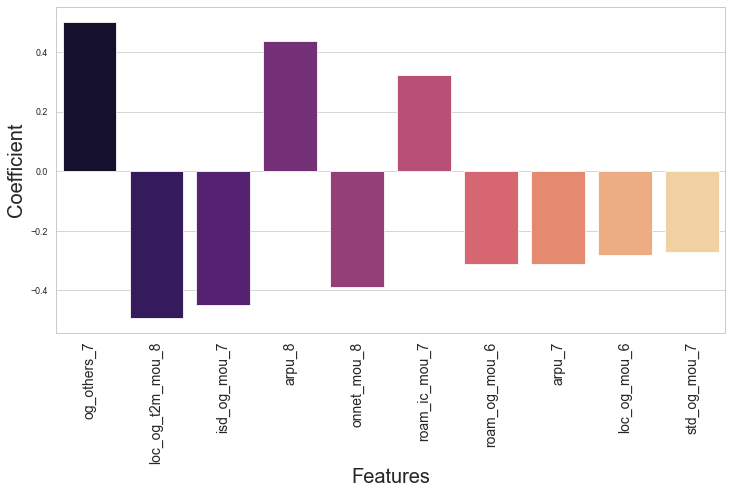

In [154]:
pca_column_frame = pca_df.head(50)
pca_column_frame['sampling_coeff'] = model1.coef_[0]
plt.figure(figsize=(12, 6))
top_10_features = pca_column_frame.iloc[(-np.abs(pca_column_frame['sampling_coeff'].values)).argsort()].head(10)
sns.barplot(x='Feature', y='sampling_coeff', data=top_10_features,palette='magma')
plt.xlabel('Features', size=20)
plt.ylabel('Coefficient', size=20)
plt.xticks(size = 14, rotation='vertical')
plt.show();

### Recomendations 
The top features which the Churn Increases are 
- og_Others_7
- arpu_8
- roam_ic_mou_7
So if these increases the Customer can be given some discounts or offers so that he/she doesn't turn into Churn

In the month of Jun 

- The increase in Loc_og_mou_6 along with roam_og_mou_6 values will decrease the probability of Churn hence the Customer can be given some offers so that he/she can continue increasing the out going and can be given some offer where the customer can go ahead and continue with roaming outgoing with a nominal price. 

In the month of Jul 

- The increase in isd_Og_mou_7 (outgoing in the month of July) ,roam_ic_mou_7(roaming on incoming calls in the month of July), STD_og_omu_7(std out going in the month of Jul) and arpu_7 will decrease the probability of Churn.
- Hence the Users can be given a powerpack with a nominal cost so that these values can be increased . 

## 13.2 IntpModel - LogisticRegression - Interpretation

monthly_3g_8_1          1.301313
monthly_2g_8_Others     1.092070
days_since_last_rech    0.884486
monthly_2g_8_1          0.852745
roam_ic_mou_8           0.818465
last_day_rch_amt_8      0.702968
monthly_2g_6_Others     0.697368
monthly_2g_7_Others     0.648688
sachet_3g_8_Others      0.590407
arpu_8                  0.499152
sachet_3g_7_Others      0.456040
count_rech_2g_8         0.413546
monthly_2g_6_1          0.383921
sachet_2g_7_1           0.350657
arpu_7                  0.341040
std_ic_t2m_mou_8        0.324440
loc_og_t2m_mou_6        0.299113
arpu_6                  0.294809
sachet_2g_6_2           0.277588
sachet_3g_6_1           0.266651
sachet_2g_8_1           0.262022
aon                     0.255475
fb_user_7_1.0           0.118718
Name: Feature Importance, dtype: float64

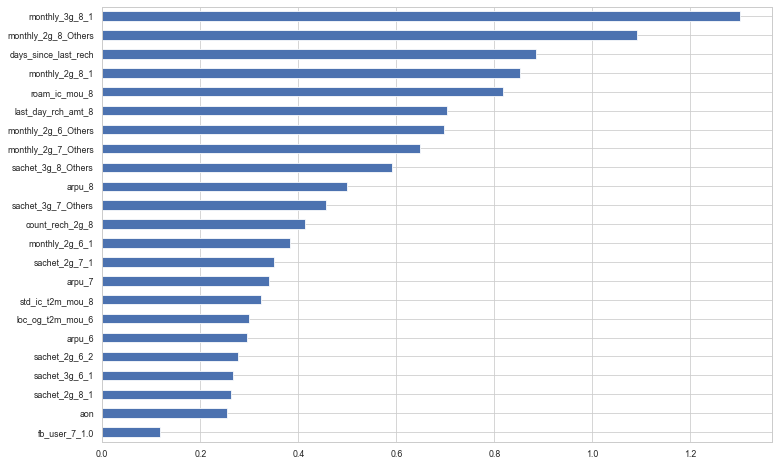

In [155]:
coeff = pd.DataFrame({'Feature Importance':modellog.coef_.tolist()[0]}, index=X_test_rfe.columns)
coeff[coeff['Feature Importance'] != 0]['Feature Importance'].abs().sort_values().plot(kind='barh',figsize=(12,8))
coeff['Feature Importance'].abs().sort_values(ascending = False)

In [156]:
coeff['Feature Importance'].sort_values(ascending = False)

days_since_last_rech    0.884486
roam_ic_mou_8           0.818465
sachet_3g_7_Others      0.456040
arpu_7                  0.341040
arpu_6                  0.294809
sachet_2g_8_1           0.262022
fb_user_7_1.0           0.118718
aon                    -0.255475
sachet_3g_6_1          -0.266651
sachet_2g_6_2          -0.277588
loc_og_t2m_mou_6       -0.299113
std_ic_t2m_mou_8       -0.324440
sachet_2g_7_1          -0.350657
monthly_2g_6_1         -0.383921
count_rech_2g_8        -0.413546
arpu_8                 -0.499152
sachet_3g_8_Others     -0.590407
monthly_2g_7_Others    -0.648688
monthly_2g_6_Others    -0.697368
last_day_rch_amt_8     -0.702968
monthly_2g_8_1         -0.852745
monthly_2g_8_Others    -1.092070
monthly_3g_8_1         -1.301313
Name: Feature Importance, dtype: float64

## Inferences and Recomendations 

If  last_day_rch_amt_8   increases the churn probability decreses .
Hence Users can be given some offers to recharge and increase the validity and it will lessen the chances of churn .

- Positively influencing columns for June
    - arpu_6
- Negatively influencing columns for June
    - sachet_3g_6_1         
    - sachet_2g_6_2    
    - loc_ic_t2f_mou_6
    - monthly_2g_6_1
    - monthly_2g_6_Others

With Increase in **arpu_6** the chances of churn increases  and with increase in **sachet_3g_6_1,sachet_2g_6_2,loc_ic_t2f_mou_6,monthly_2g_6_1,monthly_2g_6_Others** the Chances of churn decreases .

So the users can be given a powerpack where all these facilities can be bundeled eg. A powerpack with a nominal value which will give free local incoming , with 2g/3g data pack as a additional pack which can lessen the chances of Churn.
- The user can be given 3g/2g Data packs with less cost .

- Positively influencing columns for July 
    - arpu_7
    - sachet_3g_7_Others
    - fb_user_7_1.0
- Negatively influencing columns for July 
    - sachet_2g_7_1
    - monthly_2g_7_Others
    
With Increase in 2g Schaet recharge , 2g ther data recharge , the churn can be reduced hence the users can be given a Powerpack with 2g data which will increase their data consumption and will reduce the churn.   

- Positively influencing columns for August 
    - roam_ic_mou_8	
    - sachet_2g_8_1		  
- Negatively influencing columns for August 
    - std_ic_t2m_mou_8
    - count_rech_2g_8	
    - arpu_8
    - sachet_3g_8_Others
    - monthly_2g_8_1         
    - monthly_2g_8_Others   
    - monthly_3g_8_1 

For August 2g/3g data related recharges can decrease the probability of Churn.

**2g/3g related columns which will decrease the probability of churn with increase in their values**

- sachet_3g_7_Others 
- sachet_2g_8_1           	
- sachet_3g_6_1          	
- sachet_2g_6_2          
- sachet_2g_7_1     
- monthly_2g_6_1         
- count_rech_2g_8        
- sachet_3g_8_Others     
- monthly_2g_7_Others    
- monthly_2g_6_Others       
- monthly_2g_8_1         
- monthly_2g_8_Others    
- monthly_3g_8_1         

This signifies The Customers need more mobile data in order not to churn .
Hence the company can come up with some kind of Data packs with nominal costs 

## 14. Refined Recomendations /Stratigies for Business
- If  last_day_rch_amt_8   increases the churn probability decreses .Hence Users can be given some offers to recharge and increase the validity in 3rd month and it will lessen the chances of churn.
- In the first Month, A powerpack with a nominal value that will give free local incoming, with 2g/3g data pack as an additional pack can lessen the chances of Churn. The company should look into the same.
- In the second month, With an Increase in 2g Schaet recharge, 2g data recharge, the churn can be reduced hence the users can be given a Powerpack with 2g data which will increase their data consumption and will reduce the churn.
- In the third Month data related recharges can decrease the probability of Churn. Hence Users can be given offers with Data packs 
- If days_since_last_rech increases the churn probability increases. Hence Users can be given some offers to recharge and stay with the network.
- Overall The Customers need more mobile data in order not to churn. Hence the company can come up with some kind of Data packs with nominal costs to reduce churn.
